In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ShallowNetwork

# Test for RMSE

Let's test if the written shallow network class works for a simple case of fitting it to the cosine function with the RMSE loss function.

In [2]:
X = np.arange(0, 2 * np.pi, 0.03)
X = X.reshape((X.shape[0], 1, 1))
Y = np.sin(X)

## Definining loss functions

In [3]:
def loss_function_single_point(self, point, ground_truth):
        N = self.forward_pass(point, 0)
        loss = np.sqrt(((N - ground_truth) ** 2).sum())
        return loss

In [4]:
def loss_function_all(self, samples, labels):
        loss = 0
        n_inv = len(samples) ** -1
        for i in range(samples.shape[0]):
            loss += self.loss_function_single_point(self, samples[i], labels[i]) ** 2
        loss *= n_inv
        loss = np.sqrt(loss)
        return loss

## Defining the update rules

In [5]:
def bias_change_point(self, point, label):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  db_N = self.network_derivative_bias(point, 0)
  for m in range(self.hidden_dim):
    for j in range(self.visible_dim):
      db[m] += change[j] * db_N[j, 0, m]
  db /= loss
  return db

In [6]:
def hidden_weights_change_point(self, point, label):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      for j in range(self.visible_dim):
        dH[m, p] += change[j] * dH_N[j, 0, m, p]
  dH /= loss
  return dH

In [7]:
def visible_weights_change_point(self, point, label):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  dV_N = self.network_derivative_visible_weights(point, 0)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      for j in range(self.visible_dim):
        dV[m, p] += change[j] * dV_N[j, 0, m, p]
  dV /= loss
  return dV

## Defining the netowork for the task

In [8]:
network = ShallowNetwork.ShallowNetwork(loss_function=loss_function_all,
                                        loss_function_single_point=loss_function_single_point,
                                       bias_change=bias_change_point,
                                       hidden_weights_change=hidden_weights_change_point,
                                       visible_weights_change=visible_weights_change_point,
                                       hidden_dim=50, unsupervised=False, momentum=0, learning_rate=0.1)

In [9]:
network.train(samples=X, labels=Y, epochs=10)

Epoch: 1 Loss function: 0.5120795689192599
Epoch: 2 Loss function: 0.8703143898799293
Epoch: 3 Loss function: 0.750015392276769
Epoch: 4 Loss function: 0.6211892282255725
Epoch: 5 Loss function: 0.38848933918287715
Epoch: 6 Loss function: 0.2942582327811619
Epoch: 7 Loss function: 0.3129755943864241
Epoch: 8 Loss function: 0.33464396853482326
Epoch: 9 Loss function: 0.2861251455359409
Epoch: 10 Loss function: 0.3784520508341528


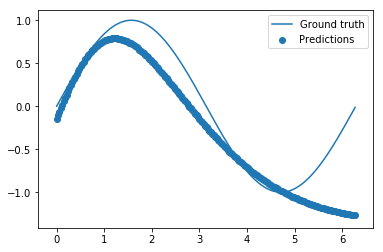

In [10]:
Y2 = np.array([network.forward_pass(X[i], 0) for i in range(X.shape[0])])
Xp = X.reshape((X.shape[0],))
Yp = Y.reshape((Y.shape[0],))
plt.plot(Xp, Yp, label='Ground truth')
plt.scatter(Xp, Y2, label='Predictions')
plt.legend()
plt.show() 

## Trial Solution class

In [11]:
class Trial_Solution:
  def __init__(self, loss_function, loss_function_single_point,
               bias_change, hidden_weights_change, visible_weights_change,
               boundary_condition_value_function, boundary_vanishing_function,
               input_dim=1, hidden_dim=1, output_dim=1, momentum=0, learning_rate=0.1):
    # Dimensions of the Shallow Network
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    
    # Defining all of the three parts of the trial solution f(X)=A(X)+B(X)N(X)
    # A(X) is a function fullfiling the boundary or initial conditions
    self.boundary_condition_value_function = boundary_condition_value_function
    # B(X) is a function vanishing on the boundary or in the initial moment
    self.boundary_vanishing_function = boundary_vanishing_function
    # N(X) is the Shallow Network
    self.network = ShallowNetwork.ShallowNetwork(
      input_dim=self.input_dim, hidden_dim=self.hidden_dim, visible_dim=self.output_dim,
      momentum=momentum, learning_rate=learning_rate, loss_function=loss_function,
      loss_function_single_point=loss_function_single_point, bias_change=bias_change,
      hidden_weights_change=hidden_weights_change, visible_weights_change=visible_weights_change,
      unsupervised=True)

  def predict(self, X):
    return self.boundary_condition_value_function(X) + self.boundary_vanishing_function(X) * self.network.forward_pass(X, 0)
    
  def train(self, samples, epochs):
    self.network.train(samples=samples, epochs=epochs, labels=None)

## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [12]:
Xe1 = np.arange(0,1,0.05) + 1e-6
Xe1 = Xe1.reshape((Xe1.shape[0],1,1))

In [13]:
def example1_initial_value(point):
  return 1

In [14]:
def example1_boundary_vanishing(point):
  return point

In [15]:
def example1_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * (1 + point * N) 
      - point ** 3 - 2 * point - (1 + 3 * point ** 2)/(1 + point + point ** 3)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [16]:
def example1_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

In [17]:
def example1_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * (
      point * db_DN[0, 0, m] + db_N[0, 0, m] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * db_N[0, 0, m])
  return db

In [18]:
def example1_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (
        point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dH_N[0, 0, m, p])
  return dH

In [19]:
def example1_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (
        point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
  return dV

In [20]:
example1_trial_solution = Trial_Solution(loss_function=example1_loss_function,
                                        loss_function_single_point=example1_loss_function_single_point,
                                        bias_change=example1_bias_change,
                                        hidden_weights_change=example1_hidden_weights_change,
                                        visible_weights_change=example1_visible_weights_change,
                                        boundary_condition_value_function=example1_initial_value,
                                        boundary_vanishing_function=example1_boundary_vanishing,
                                        input_dim=1, hidden_dim=20, output_dim=1, learning_rate=1e-1)

In [21]:
example1_trial_solution.train(Xe1, 2000)

Epoch: 1 Loss function: 0.4674823796074132
Epoch: 2 Loss function: 0.08409978413335047
Epoch: 3 Loss function: 0.010024705106047528
Epoch: 4 Loss function: 0.012165411096820112
Epoch: 5 Loss function: 0.003730421077898484
Epoch: 6 Loss function: 0.0564114092664299
Epoch: 7 Loss function: 0.015905633601649715
Epoch: 8 Loss function: 0.003597304826339436
Epoch: 9 Loss function: 1.0459191963216612
Epoch: 10 Loss function: 0.0026276380497309913
Epoch: 11 Loss function: 0.05797223838730693
Epoch: 12 Loss function: 0.00622184212864609
Epoch: 13 Loss function: 0.46796121439057803
Epoch: 14 Loss function: 0.007578263347428732
Epoch: 15 Loss function: 0.09617124797356169
Epoch: 16 Loss function: 0.5089236784126304
Epoch: 17 Loss function: 0.23964155717447538
Epoch: 18 Loss function: 0.0035617200906530116
Epoch: 19 Loss function: 0.0463716224010741
Epoch: 20 Loss function: 0.06378174303803089
Epoch: 21 Loss function: 0.005682629407973057
Epoch: 22 Loss function: 0.04231330044899382
Epoch: 23 Los

Epoch: 190 Loss function: 0.009160638726542375
Epoch: 191 Loss function: 0.0071036119078157055
Epoch: 192 Loss function: 0.04766211889642922
Epoch: 193 Loss function: 0.028883651422415474
Epoch: 194 Loss function: 0.0043384152384227884
Epoch: 195 Loss function: 0.004970182120946106
Epoch: 196 Loss function: 0.00811710886602517
Epoch: 197 Loss function: 0.013808667800808739
Epoch: 198 Loss function: 0.00830421017306681
Epoch: 199 Loss function: 0.00516607881968327
Epoch: 200 Loss function: 0.04015711590347613
Epoch: 201 Loss function: 0.004525381491798172
Epoch: 202 Loss function: 0.011921087750364243
Epoch: 203 Loss function: 0.031074590231243166
Epoch: 204 Loss function: 0.02677956390039523
Epoch: 205 Loss function: 0.005292546376192269
Epoch: 206 Loss function: 0.005000426000790361
Epoch: 207 Loss function: 0.010602724650381631
Epoch: 208 Loss function: 0.012610276263251712
Epoch: 209 Loss function: 0.005249819403055486
Epoch: 210 Loss function: 0.005496667009253153
Epoch: 211 Loss f

Epoch: 367 Loss function: 0.0091600742386606
Epoch: 368 Loss function: 0.007975601680579706
Epoch: 369 Loss function: 0.005598980322739914
Epoch: 370 Loss function: 0.006657940170759408
Epoch: 371 Loss function: 0.004845438787470881
Epoch: 372 Loss function: 0.005358405307776798
Epoch: 373 Loss function: 0.007652733349200275
Epoch: 374 Loss function: 0.004536492968844925
Epoch: 375 Loss function: 0.008718474592172589
Epoch: 376 Loss function: 0.009991756855247544
Epoch: 377 Loss function: 0.008792571589568917
Epoch: 378 Loss function: 0.004581280074326409
Epoch: 379 Loss function: 0.004844103783683452
Epoch: 380 Loss function: 0.00622958938480247
Epoch: 381 Loss function: 0.006249375077044363
Epoch: 382 Loss function: 0.010606042343456235
Epoch: 383 Loss function: 0.009774214529367742
Epoch: 384 Loss function: 0.006366809399937864
Epoch: 385 Loss function: 0.005691278547992066
Epoch: 386 Loss function: 0.00472556357567778
Epoch: 387 Loss function: 0.011612310235712556
Epoch: 388 Loss f

Epoch: 544 Loss function: 0.0043872048218697845
Epoch: 545 Loss function: 0.004392350896818713
Epoch: 546 Loss function: 0.004786210006103175
Epoch: 547 Loss function: 0.007082474307035303
Epoch: 548 Loss function: 0.005381646640373715
Epoch: 549 Loss function: 0.0043773520887827695
Epoch: 550 Loss function: 0.02812771276972434
Epoch: 551 Loss function: 0.004403153871663071
Epoch: 552 Loss function: 0.004336881341776961
Epoch: 553 Loss function: 0.004333010045543656
Epoch: 554 Loss function: 0.0043876964825118915
Epoch: 555 Loss function: 0.02642645696096683
Epoch: 556 Loss function: 0.006434348343244943
Epoch: 557 Loss function: 0.0070894920371517125
Epoch: 558 Loss function: 0.007601874322054681
Epoch: 559 Loss function: 0.005493662027388232
Epoch: 560 Loss function: 0.007272216062470127
Epoch: 561 Loss function: 0.00752487988630311
Epoch: 562 Loss function: 0.004327260334440902
Epoch: 563 Loss function: 0.005725164266200414
Epoch: 564 Loss function: 0.00432539029271529
Epoch: 565 Lo

Epoch: 720 Loss function: 0.004503952870604333
Epoch: 721 Loss function: 0.004174190673107691
Epoch: 722 Loss function: 0.004117492296185308
Epoch: 723 Loss function: 0.0069618067019679404
Epoch: 724 Loss function: 0.004170393629388923
Epoch: 725 Loss function: 0.004725414094412138
Epoch: 726 Loss function: 0.005181864196492273
Epoch: 727 Loss function: 0.00727716876292933
Epoch: 728 Loss function: 0.00684432175754818
Epoch: 729 Loss function: 0.006002987012632841
Epoch: 730 Loss function: 0.006847221271869407
Epoch: 731 Loss function: 0.009661552991432145
Epoch: 732 Loss function: 0.00506640911715857
Epoch: 733 Loss function: 0.004109901134795764
Epoch: 734 Loss function: 0.006299218698560599
Epoch: 735 Loss function: 0.007844414623837146
Epoch: 736 Loss function: 0.006321758706017681
Epoch: 737 Loss function: 0.004327148830451733
Epoch: 738 Loss function: 0.004052688804731188
Epoch: 739 Loss function: 0.005337514969203538
Epoch: 740 Loss function: 0.004150309261939166
Epoch: 741 Loss

Epoch: 896 Loss function: 0.0063847404702963625
Epoch: 897 Loss function: 0.004237019331142369
Epoch: 898 Loss function: 0.005768864188748462
Epoch: 899 Loss function: 0.00427377515590971
Epoch: 900 Loss function: 0.005333476386389696
Epoch: 901 Loss function: 0.009584607077798834
Epoch: 902 Loss function: 0.005584030305072322
Epoch: 903 Loss function: 0.004050299792965474
Epoch: 904 Loss function: 0.010188666128425821
Epoch: 905 Loss function: 0.004057684964495301
Epoch: 906 Loss function: 0.003869485938576491
Epoch: 907 Loss function: 0.004389786416969502
Epoch: 908 Loss function: 0.004032474125079227
Epoch: 909 Loss function: 0.0038742972473369735
Epoch: 910 Loss function: 0.003807522519808262
Epoch: 911 Loss function: 0.0066033764190249564
Epoch: 912 Loss function: 0.003825312407019668
Epoch: 913 Loss function: 0.00417496978567985
Epoch: 914 Loss function: 0.0038309360476203396
Epoch: 915 Loss function: 0.004185908598587962
Epoch: 916 Loss function: 0.003814278315219586
Epoch: 917 

Epoch: 1069 Loss function: 0.00375213234092575
Epoch: 1070 Loss function: 0.004788280872361733
Epoch: 1071 Loss function: 0.0035727453007308265
Epoch: 1072 Loss function: 0.0038402255920492166
Epoch: 1073 Loss function: 0.005002663811988361
Epoch: 1074 Loss function: 0.00887599339573066
Epoch: 1075 Loss function: 0.003587395405159337
Epoch: 1076 Loss function: 0.0036591809318071893
Epoch: 1077 Loss function: 0.00421436868234039
Epoch: 1078 Loss function: 0.007108736934719967
Epoch: 1079 Loss function: 0.00354615837242715
Epoch: 1080 Loss function: 0.0047184632911121335
Epoch: 1081 Loss function: 0.003598128052522991
Epoch: 1082 Loss function: 0.0037067092812281648
Epoch: 1083 Loss function: 0.003546460617690845
Epoch: 1084 Loss function: 0.0043962960214338365
Epoch: 1085 Loss function: 0.0036645785858797375
Epoch: 1086 Loss function: 0.003541822691936034
Epoch: 1087 Loss function: 0.00459152966958839
Epoch: 1088 Loss function: 0.0035928645085127804
Epoch: 1089 Loss function: 0.00458192

Epoch: 1240 Loss function: 0.003485945492017638
Epoch: 1241 Loss function: 0.003584777748301979
Epoch: 1242 Loss function: 0.004115139087878169
Epoch: 1243 Loss function: 0.0033179443998291964
Epoch: 1244 Loss function: 0.004359652998936301
Epoch: 1245 Loss function: 0.0034617089346994116
Epoch: 1246 Loss function: 0.0041080334851642765
Epoch: 1247 Loss function: 0.003595191644786702
Epoch: 1248 Loss function: 0.004775654501997692
Epoch: 1249 Loss function: 0.0033140429001153543
Epoch: 1250 Loss function: 0.00390857882707805
Epoch: 1251 Loss function: 0.003875145727313501
Epoch: 1252 Loss function: 0.003659169758640499
Epoch: 1253 Loss function: 0.0036550120365764866
Epoch: 1254 Loss function: 0.004097482780858434
Epoch: 1255 Loss function: 0.0038800308407846646
Epoch: 1256 Loss function: 0.0034406162101009385
Epoch: 1257 Loss function: 0.0033274984902969145
Epoch: 1258 Loss function: 0.0042117757883703135
Epoch: 1259 Loss function: 0.00405974118074579
Epoch: 1260 Loss function: 0.0035

Epoch: 1410 Loss function: 0.00374455275270772
Epoch: 1411 Loss function: 0.0039109723727530025
Epoch: 1412 Loss function: 0.003390723146530796
Epoch: 1413 Loss function: 0.0032417839770382496
Epoch: 1414 Loss function: 0.003395258948398196
Epoch: 1415 Loss function: 0.0034356785214759837
Epoch: 1416 Loss function: 0.0031083210661750267
Epoch: 1417 Loss function: 0.00317105535506359
Epoch: 1418 Loss function: 0.0034298388784496196
Epoch: 1419 Loss function: 0.0038068157715012477
Epoch: 1420 Loss function: 0.003955776739584838
Epoch: 1421 Loss function: 0.0031545977373004094
Epoch: 1422 Loss function: 0.003548385838734478
Epoch: 1423 Loss function: 0.004013780126677435
Epoch: 1424 Loss function: 0.0033375183930249414
Epoch: 1425 Loss function: 0.003075570936489242
Epoch: 1426 Loss function: 0.0032842610877973125
Epoch: 1427 Loss function: 0.003470458311663533
Epoch: 1428 Loss function: 0.003298363216360057
Epoch: 1429 Loss function: 0.0030703197087753264
Epoch: 1430 Loss function: 0.003

Epoch: 1582 Loss function: 0.003556930518909257
Epoch: 1583 Loss function: 0.003527352604219605
Epoch: 1584 Loss function: 0.003067145804288269
Epoch: 1585 Loss function: 0.004136129011566209
Epoch: 1586 Loss function: 0.002855378329057643
Epoch: 1587 Loss function: 0.0029068187856422806
Epoch: 1588 Loss function: 0.004027871090702789
Epoch: 1589 Loss function: 0.003004815550349345
Epoch: 1590 Loss function: 0.003030604965218933
Epoch: 1591 Loss function: 0.0029092838313063427
Epoch: 1592 Loss function: 0.003043715931779829
Epoch: 1593 Loss function: 0.0029294248667965815
Epoch: 1594 Loss function: 0.0029850876514901084
Epoch: 1595 Loss function: 0.0028954888351632856
Epoch: 1596 Loss function: 0.0029240889108936787
Epoch: 1597 Loss function: 0.0029430081329092626
Epoch: 1598 Loss function: 0.003302607815790432
Epoch: 1599 Loss function: 0.00314173218384979
Epoch: 1600 Loss function: 0.004750745642418311
Epoch: 1601 Loss function: 0.0028766232912160574
Epoch: 1602 Loss function: 0.0029

Epoch: 1753 Loss function: 0.0028368859705941558
Epoch: 1754 Loss function: 0.0027299772682003037
Epoch: 1755 Loss function: 0.0029815007988550782
Epoch: 1756 Loss function: 0.0026290203246335173
Epoch: 1757 Loss function: 0.0027613520416237543
Epoch: 1758 Loss function: 0.002638812732649295
Epoch: 1759 Loss function: 0.0035809284054368236
Epoch: 1760 Loss function: 0.0026469684659936794
Epoch: 1761 Loss function: 0.002649969906960294
Epoch: 1762 Loss function: 0.0026224168588362376
Epoch: 1763 Loss function: 0.0026488856419261326
Epoch: 1764 Loss function: 0.002618615092134418
Epoch: 1765 Loss function: 0.002650327006295053
Epoch: 1766 Loss function: 0.0026876906444202853
Epoch: 1767 Loss function: 0.002624434018847224
Epoch: 1768 Loss function: 0.0026206593359096313
Epoch: 1769 Loss function: 0.002977515974237707
Epoch: 1770 Loss function: 0.003119100573448841
Epoch: 1771 Loss function: 0.0027172794275749706
Epoch: 1772 Loss function: 0.002703192777267925
Epoch: 1773 Loss function: 0

Epoch: 1923 Loss function: 0.0034821141328033227
Epoch: 1924 Loss function: 0.0024890122399973433
Epoch: 1925 Loss function: 0.0038576141710447267
Epoch: 1926 Loss function: 0.0024053969563988032
Epoch: 1927 Loss function: 0.002602176857677474
Epoch: 1928 Loss function: 0.0024131957349566944
Epoch: 1929 Loss function: 0.0027356412296094764
Epoch: 1930 Loss function: 0.0025693119249641607
Epoch: 1931 Loss function: 0.002731368660873955
Epoch: 1932 Loss function: 0.0025042095497432915
Epoch: 1933 Loss function: 0.002420803557711327
Epoch: 1934 Loss function: 0.0036037168660418874
Epoch: 1935 Loss function: 0.002926706276034827
Epoch: 1936 Loss function: 0.0028492231957464205
Epoch: 1937 Loss function: 0.002434501144884921
Epoch: 1938 Loss function: 0.002401755075698413
Epoch: 1939 Loss function: 0.0025833199544905653
Epoch: 1940 Loss function: 0.002567573529514597
Epoch: 1941 Loss function: 0.002546427820673934
Epoch: 1942 Loss function: 0.0024573450536961904
Epoch: 1943 Loss function: 0

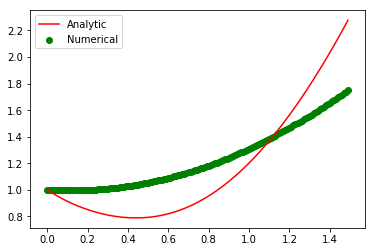

In [22]:
Xe1plot = np.arange(0,1.5, 0.01)
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0], 1, 1))
Ye1 = np.array([example1_trial_solution.predict(Xe1plot[i]) for i in range(Xe1plot.shape[0])]).reshape((Xe1plot.shape[0],))
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0],))
Ye12 = np.array([np.exp(-0.5*Xe1plot[i]**2)/(1+Xe1plot[i]+Xe1plot[i]**3) + Xe1plot[i]**2 for i in range(Xe1plot.shape[0])])
plt.scatter(Xe1plot, Ye1, c='g', label='Numerical')
plt.plot(Xe1plot, Ye12, c='r', label='Analytic')
plt.legend()
plt.show()

## Example 2

$\frac{d}{dx}\Psi+\frac{1}{5}\Psi=\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$ and domain $x\in[0,2]$

In [23]:
Xe2 = np.arange(0,2,0.1) + 1e-6
Xe2 = Xe2.reshape((Xe2.shape[0],1,1))

In [24]:
def example2_initial_value(point):
  return 0

In [25]:
def example2_boundary_vanishing(point):
  return point

In [26]:
def example2_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + 0.2 * point * N 
      - np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [27]:
def example2_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

In [28]:
def example2_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( point * db_DN[0, 0, m] + db_N[0, 0, m] + 0.2 * point * db_N[0, 0, m])
  return db

In [29]:
def example2_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * ( point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + 0.2 * point * dH_N[0, 0, m, p])
  return dH

In [30]:
def example2_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + 0.2 * point * dV_N[0, 0, m, p])
  return dV

In [31]:
example2_trial_solution = Trial_Solution(loss_function=example2_loss_function,
                                        loss_function_single_point=example2_loss_function_single_point,
                                        bias_change=example2_bias_change,
                                        hidden_weights_change=example2_hidden_weights_change,
                                        visible_weights_change=example2_visible_weights_change,
                                        boundary_condition_value_function=example2_initial_value,
                                        boundary_vanishing_function=example2_boundary_vanishing,
                                        input_dim=1, hidden_dim=50, output_dim=1, learning_rate=1e-1)

In [34]:
example2_trial_solution.train(Xe2, 10000)

Epoch: 1 Loss function: 2.734561611814988e-05
Epoch: 2 Loss function: 2.36364963685409e-05
Epoch: 3 Loss function: 2.6402694724389618e-05
Epoch: 4 Loss function: 3.3455906237102536e-05
Epoch: 5 Loss function: 4.171974250608908e-05
Epoch: 6 Loss function: 2.9671225233313704e-05
Epoch: 7 Loss function: 2.2415150845730314e-05
Epoch: 8 Loss function: 2.4721635832746977e-05
Epoch: 9 Loss function: 2.7414506100851154e-05
Epoch: 10 Loss function: 2.7982951392368696e-05
Epoch: 11 Loss function: 3.2970286885336285e-05
Epoch: 12 Loss function: 2.8893377328990657e-05
Epoch: 13 Loss function: 9.346503271334653e-05
Epoch: 14 Loss function: 6.229923382411977e-05
Epoch: 15 Loss function: 3.191244871069014e-05
Epoch: 16 Loss function: 2.7061691502058695e-05
Epoch: 17 Loss function: 2.2206605812680824e-05
Epoch: 18 Loss function: 2.6269326238537214e-05
Epoch: 19 Loss function: 2.42039163678384e-05
Epoch: 20 Loss function: 5.737836562177385e-05
Epoch: 21 Loss function: 3.286137384801347e-05
Epoch: 22 Lo

Epoch: 173 Loss function: 1.3710807017253546e-05
Epoch: 174 Loss function: 7.201439302827422e-05
Epoch: 175 Loss function: 1.6704592921586948e-05
Epoch: 176 Loss function: 1.3289965816729982e-05
Epoch: 177 Loss function: 1.7885406357040094e-05
Epoch: 178 Loss function: 1.9551755616708458e-05
Epoch: 179 Loss function: 1.583033461684293e-05
Epoch: 180 Loss function: 1.3101335651469762e-05
Epoch: 181 Loss function: 2.026735479064518e-05
Epoch: 182 Loss function: 1.5710728601680715e-05
Epoch: 183 Loss function: 1.3313957505250166e-05
Epoch: 184 Loss function: 1.3604806869720754e-05
Epoch: 185 Loss function: 2.1964220430305582e-05
Epoch: 186 Loss function: 1.3742216430215018e-05
Epoch: 187 Loss function: 2.2603510328893934e-05
Epoch: 188 Loss function: 2.5448241681741613e-05
Epoch: 189 Loss function: 1.3521668580913419e-05
Epoch: 190 Loss function: 2.5410712162717235e-05
Epoch: 191 Loss function: 1.4283200349834522e-05
Epoch: 192 Loss function: 4.423419528799129e-05
Epoch: 193 Loss function

Epoch: 342 Loss function: 1.3971381794026499e-05
Epoch: 343 Loss function: 1.377357055262081e-05
Epoch: 344 Loss function: 7.156736790003308e-05
Epoch: 345 Loss function: 1.3317000307385061e-05
Epoch: 346 Loss function: 9.867965503110527e-06
Epoch: 347 Loss function: 1.1586299698962188e-05
Epoch: 348 Loss function: 1.2216138524682698e-05
Epoch: 349 Loss function: 9.54376921407738e-06
Epoch: 350 Loss function: 8.834401583283726e-06
Epoch: 351 Loss function: 1.3543741233825908e-05
Epoch: 352 Loss function: 1.553410815314665e-05
Epoch: 353 Loss function: 9.472465389287353e-06
Epoch: 354 Loss function: 1.8254461039597143e-05
Epoch: 355 Loss function: 9.969141273956598e-06
Epoch: 356 Loss function: 1.5096391969413942e-05
Epoch: 357 Loss function: 1.1859336168542177e-05
Epoch: 358 Loss function: 8.59690238906911e-06
Epoch: 359 Loss function: 2.251730891144375e-05
Epoch: 360 Loss function: 1.3422330005039244e-05
Epoch: 361 Loss function: 9.127936946024432e-06
Epoch: 362 Loss function: 1.11877

Epoch: 512 Loss function: 1.043647738414035e-05
Epoch: 513 Loss function: 9.405578659137634e-06
Epoch: 514 Loss function: 6.972333820848197e-06
Epoch: 515 Loss function: 8.18522464469699e-06
Epoch: 516 Loss function: 8.013564717614414e-06
Epoch: 517 Loss function: 6.564138856753253e-06
Epoch: 518 Loss function: 1.1034212706382653e-05
Epoch: 519 Loss function: 7.63810616286201e-06
Epoch: 520 Loss function: 3.493321431141142e-05
Epoch: 521 Loss function: 5.813213246675982e-06
Epoch: 522 Loss function: 5.9017299802897425e-06
Epoch: 523 Loss function: 6.0457253849219904e-06
Epoch: 524 Loss function: 5.972132369190921e-06
Epoch: 525 Loss function: 2.351480886138844e-05
Epoch: 526 Loss function: 5.938942656186226e-06
Epoch: 527 Loss function: 7.115151777989134e-06
Epoch: 528 Loss function: 6.1320120816488366e-06
Epoch: 529 Loss function: 6.847144918793803e-06
Epoch: 530 Loss function: 9.792355260182141e-06
Epoch: 531 Loss function: 8.604310893350846e-06
Epoch: 532 Loss function: 6.1959306861

Epoch: 683 Loss function: 4.62042300046971e-06
Epoch: 684 Loss function: 5.497714215455615e-06
Epoch: 685 Loss function: 6.797672670382071e-06
Epoch: 686 Loss function: 4.689550030305845e-06
Epoch: 687 Loss function: 4.5079797773207245e-06
Epoch: 688 Loss function: 4.2728186812517825e-06
Epoch: 689 Loss function: 6.228565493085811e-06
Epoch: 690 Loss function: 1.0559135957878131e-05
Epoch: 691 Loss function: 7.5710157011458854e-06
Epoch: 692 Loss function: 6.734706116415457e-06
Epoch: 693 Loss function: 4.429022445833738e-06
Epoch: 694 Loss function: 7.295230454452201e-06
Epoch: 695 Loss function: 4.293232578058575e-06
Epoch: 696 Loss function: 5.49292950850671e-06
Epoch: 697 Loss function: 5.485076593467365e-06
Epoch: 698 Loss function: 5.0223530766230664e-06
Epoch: 699 Loss function: 4.371237613230439e-06
Epoch: 700 Loss function: 4.478355166573555e-06
Epoch: 701 Loss function: 4.226141850763128e-06
Epoch: 702 Loss function: 4.3444793788681715e-06
Epoch: 703 Loss function: 6.94196655

Epoch: 854 Loss function: 3.4957232851847107e-06
Epoch: 855 Loss function: 3.6779816960215577e-06
Epoch: 856 Loss function: 6.239099690342855e-06
Epoch: 857 Loss function: 3.6087092845066516e-06
Epoch: 858 Loss function: 3.471220751745255e-06
Epoch: 859 Loss function: 3.954599196133978e-06
Epoch: 860 Loss function: 4.741645491005204e-06
Epoch: 861 Loss function: 4.714735393065577e-06
Epoch: 862 Loss function: 1.7341090272287586e-05
Epoch: 863 Loss function: 3.660211680495362e-06
Epoch: 864 Loss function: 3.75484735194595e-06
Epoch: 865 Loss function: 3.749419810229494e-06
Epoch: 866 Loss function: 3.3220089033840696e-06
Epoch: 867 Loss function: 4.86504723542927e-06
Epoch: 868 Loss function: 3.336790951188064e-06
Epoch: 869 Loss function: 1.1452691984475805e-05
Epoch: 870 Loss function: 9.566658299457575e-06
Epoch: 871 Loss function: 3.6524320258490984e-06
Epoch: 872 Loss function: 3.3279309792561984e-06
Epoch: 873 Loss function: 1.2517475617517722e-05
Epoch: 874 Loss function: 3.91333

Epoch: 1023 Loss function: 2.760271303752986e-06
Epoch: 1024 Loss function: 3.2112247588939836e-06
Epoch: 1025 Loss function: 2.8304366202176484e-06
Epoch: 1026 Loss function: 1.0857210938854879e-05
Epoch: 1027 Loss function: 2.7279167267833103e-06
Epoch: 1028 Loss function: 2.8054717943757252e-06
Epoch: 1029 Loss function: 3.0098965861790304e-06
Epoch: 1030 Loss function: 5.288624437900468e-06
Epoch: 1031 Loss function: 2.8664228026614236e-06
Epoch: 1032 Loss function: 2.9554277254413175e-06
Epoch: 1033 Loss function: 3.7283246632558914e-06
Epoch: 1034 Loss function: 2.7475519464176107e-06
Epoch: 1035 Loss function: 2.7439262141895966e-06
Epoch: 1036 Loss function: 3.6140219233297466e-06
Epoch: 1037 Loss function: 3.2487309610863024e-06
Epoch: 1038 Loss function: 5.956009709618873e-06
Epoch: 1039 Loss function: 3.860465792100881e-06
Epoch: 1040 Loss function: 3.594677198706772e-06
Epoch: 1041 Loss function: 2.7842338090444892e-06
Epoch: 1042 Loss function: 4.024720179956193e-06
Epoch:

Epoch: 1188 Loss function: 2.4696968781029502e-06
Epoch: 1189 Loss function: 3.6838642264492146e-06
Epoch: 1190 Loss function: 2.5274663958436517e-06
Epoch: 1191 Loss function: 2.4963339169962293e-06
Epoch: 1192 Loss function: 2.9356386794251014e-06
Epoch: 1193 Loss function: 2.4797963361234726e-06
Epoch: 1194 Loss function: 4.636521368751852e-06
Epoch: 1195 Loss function: 2.6450489316378423e-06
Epoch: 1196 Loss function: 9.885636169716564e-06
Epoch: 1197 Loss function: 2.378794110208797e-06
Epoch: 1198 Loss function: 8.911348010933546e-06
Epoch: 1199 Loss function: 2.49691091484298e-06
Epoch: 1200 Loss function: 8.974382047436932e-06
Epoch: 1201 Loss function: 2.49449408288001e-06
Epoch: 1202 Loss function: 6.262628271580381e-06
Epoch: 1203 Loss function: 2.3945699144542687e-06
Epoch: 1204 Loss function: 2.521180156040741e-06
Epoch: 1205 Loss function: 2.536588985874326e-06
Epoch: 1206 Loss function: 2.396288155997511e-06
Epoch: 1207 Loss function: 2.4646635541452365e-06
Epoch: 1208 L

Epoch: 1356 Loss function: 6.272317459506764e-06
Epoch: 1357 Loss function: 2.2088477460519215e-06
Epoch: 1358 Loss function: 2.1312952970174116e-06
Epoch: 1359 Loss function: 2.6038661393798014e-06
Epoch: 1360 Loss function: 2.3140495150052744e-06
Epoch: 1361 Loss function: 4.501417199579773e-06
Epoch: 1362 Loss function: 2.2137511052524123e-06
Epoch: 1363 Loss function: 2.2579983624851093e-06
Epoch: 1364 Loss function: 2.11389725908759e-06
Epoch: 1365 Loss function: 4.408121848780204e-06
Epoch: 1366 Loss function: 3.2277433240487413e-06
Epoch: 1367 Loss function: 3.6310016804176616e-06
Epoch: 1368 Loss function: 2.8706126175039414e-06
Epoch: 1369 Loss function: 2.119507836546279e-06
Epoch: 1370 Loss function: 2.31931614645088e-06
Epoch: 1371 Loss function: 2.8642514278329658e-06
Epoch: 1372 Loss function: 2.123184985340187e-06
Epoch: 1373 Loss function: 9.302614422914277e-06
Epoch: 1374 Loss function: 2.4246403365776217e-06
Epoch: 1375 Loss function: 8.12259586663274e-06
Epoch: 1376 

Epoch: 1524 Loss function: 3.0572322301057355e-06
Epoch: 1525 Loss function: 2.3246143278556055e-06
Epoch: 1526 Loss function: 2.588802496330454e-06
Epoch: 1527 Loss function: 1.9971335689301037e-06
Epoch: 1528 Loss function: 1.992189828248616e-06
Epoch: 1529 Loss function: 2.1647326507588465e-06
Epoch: 1530 Loss function: 7.106392560707883e-06
Epoch: 1531 Loss function: 2.554825706891535e-06
Epoch: 1532 Loss function: 2.6349271598122384e-06
Epoch: 1533 Loss function: 2.3940489125924104e-06
Epoch: 1534 Loss function: 2.473652989846964e-06
Epoch: 1535 Loss function: 2.7249938955963135e-06
Epoch: 1536 Loss function: 3.413771026664942e-06
Epoch: 1537 Loss function: 3.0139238598417863e-06
Epoch: 1538 Loss function: 2.0429620842009982e-06
Epoch: 1539 Loss function: 2.460069304664252e-06
Epoch: 1540 Loss function: 2.3541834530882357e-06
Epoch: 1541 Loss function: 2.0451919550045516e-06
Epoch: 1542 Loss function: 2.2201272275604956e-06
Epoch: 1543 Loss function: 2.20540707445508e-06
Epoch: 15

Epoch: 1691 Loss function: 2.035821355610332e-06
Epoch: 1692 Loss function: 2.6519082000599e-06
Epoch: 1693 Loss function: 2.146894302482051e-06
Epoch: 1694 Loss function: 1.969290528871527e-06
Epoch: 1695 Loss function: 1.9249550065032903e-06
Epoch: 1696 Loss function: 5.160906437469313e-06
Epoch: 1697 Loss function: 2.4321410877596925e-06
Epoch: 1698 Loss function: 2.4911221603277273e-06
Epoch: 1699 Loss function: 2.6258226882557345e-06
Epoch: 1700 Loss function: 2.719433559593133e-06
Epoch: 1701 Loss function: 2.0296704260047856e-06
Epoch: 1702 Loss function: 1.9140407290125747e-06
Epoch: 1703 Loss function: 6.028894937953197e-06
Epoch: 1704 Loss function: 3.4013987163198538e-06
Epoch: 1705 Loss function: 1.928739705564444e-06
Epoch: 1706 Loss function: 2.2088999427159556e-06
Epoch: 1707 Loss function: 2.3235043906367836e-06
Epoch: 1708 Loss function: 5.745197021847421e-06
Epoch: 1709 Loss function: 2.795906903543923e-06
Epoch: 1710 Loss function: 2.1951253117888735e-06
Epoch: 1711 

Epoch: 1856 Loss function: 2.066082254172933e-06
Epoch: 1857 Loss function: 3.178498010658032e-06
Epoch: 1858 Loss function: 2.4683658546708213e-06
Epoch: 1859 Loss function: 1.9488746106990424e-06
Epoch: 1860 Loss function: 2.9164960244524663e-06
Epoch: 1861 Loss function: 2.306932314680717e-06
Epoch: 1862 Loss function: 1.99797745834972e-06
Epoch: 1863 Loss function: 1.9419808945818898e-06
Epoch: 1864 Loss function: 2.299998344807531e-06
Epoch: 1865 Loss function: 5.5206512760567235e-06
Epoch: 1866 Loss function: 4.492087844123208e-06
Epoch: 1867 Loss function: 3.947284026517205e-06
Epoch: 1868 Loss function: 1.8852039740329932e-06
Epoch: 1869 Loss function: 3.2770164824305816e-06
Epoch: 1870 Loss function: 1.858801250075548e-06
Epoch: 1871 Loss function: 2.7947543550887432e-06
Epoch: 1872 Loss function: 1.845149960447244e-06
Epoch: 1873 Loss function: 1.9350507709719697e-06
Epoch: 1874 Loss function: 1.9147312121935612e-06
Epoch: 1875 Loss function: 2.0495596936594533e-06
Epoch: 187

Epoch: 2022 Loss function: 1.7993792562218852e-06
Epoch: 2023 Loss function: 1.853941870054638e-06
Epoch: 2024 Loss function: 5.996662383503586e-06
Epoch: 2025 Loss function: 1.8336799991246094e-06
Epoch: 2026 Loss function: 1.8062291210206429e-06
Epoch: 2027 Loss function: 2.0909894808293972e-06
Epoch: 2028 Loss function: 2.1813513969813265e-06
Epoch: 2029 Loss function: 5.003382252188403e-06
Epoch: 2030 Loss function: 2.866123779204581e-06
Epoch: 2031 Loss function: 4.868549207266318e-06
Epoch: 2032 Loss function: 2.4210967316266406e-06
Epoch: 2033 Loss function: 2.3718167934682323e-06
Epoch: 2034 Loss function: 1.8096617063317267e-06
Epoch: 2035 Loss function: 1.7872313487031405e-06
Epoch: 2036 Loss function: 1.7736306028477958e-06
Epoch: 2037 Loss function: 1.781981214090957e-06
Epoch: 2038 Loss function: 3.4987698657004324e-06
Epoch: 2039 Loss function: 3.4687954038235283e-06
Epoch: 2040 Loss function: 1.886010387286794e-06
Epoch: 2041 Loss function: 1.7825684386220753e-06
Epoch: 

Epoch: 2188 Loss function: 2.360714528935517e-06
Epoch: 2189 Loss function: 3.347464024855316e-06
Epoch: 2190 Loss function: 4.029007107249884e-06
Epoch: 2191 Loss function: 2.9266676671677854e-06
Epoch: 2192 Loss function: 2.0260229057190612e-06
Epoch: 2193 Loss function: 1.8799554498115173e-06
Epoch: 2194 Loss function: 2.4677830345249465e-06
Epoch: 2195 Loss function: 2.3534211582142215e-06
Epoch: 2196 Loss function: 1.8314721349976706e-06
Epoch: 2197 Loss function: 2.9028954307300436e-06
Epoch: 2198 Loss function: 1.74565558749088e-06
Epoch: 2199 Loss function: 1.8341714741250674e-06
Epoch: 2200 Loss function: 1.771740901743914e-06
Epoch: 2201 Loss function: 2.063187533224489e-06
Epoch: 2202 Loss function: 1.7496519190655245e-06
Epoch: 2203 Loss function: 3.892729145009017e-06
Epoch: 2204 Loss function: 2.1028911445060576e-06
Epoch: 2205 Loss function: 2.352591250837696e-06
Epoch: 2206 Loss function: 2.394621989634002e-06
Epoch: 2207 Loss function: 2.719314411281262e-06
Epoch: 2208

Epoch: 2355 Loss function: 1.9027877399499344e-06
Epoch: 2356 Loss function: 1.8001815206387078e-06
Epoch: 2357 Loss function: 2.8224481538520977e-06
Epoch: 2358 Loss function: 2.606823376424647e-06
Epoch: 2359 Loss function: 1.787614822303933e-06
Epoch: 2360 Loss function: 1.7223019939906518e-06
Epoch: 2361 Loss function: 2.173436819407688e-06
Epoch: 2362 Loss function: 2.656803534457973e-06
Epoch: 2363 Loss function: 1.8941503696346626e-06
Epoch: 2364 Loss function: 1.72476392155844e-06
Epoch: 2365 Loss function: 2.6976680304105136e-06
Epoch: 2366 Loss function: 2.312347039443667e-06
Epoch: 2367 Loss function: 1.7706420369872405e-06
Epoch: 2368 Loss function: 2.0355137671784032e-06
Epoch: 2369 Loss function: 2.27342768221745e-06
Epoch: 2370 Loss function: 2.274108529123408e-06
Epoch: 2371 Loss function: 2.331365330543171e-06
Epoch: 2372 Loss function: 4.912004333844915e-06
Epoch: 2373 Loss function: 1.7246635660757573e-06
Epoch: 2374 Loss function: 1.7355688037432646e-06
Epoch: 2375 

Epoch: 2521 Loss function: 2.509445525199996e-06
Epoch: 2522 Loss function: 2.4924451654231627e-06
Epoch: 2523 Loss function: 2.8731054691682084e-06
Epoch: 2524 Loss function: 3.5786579977510698e-06
Epoch: 2525 Loss function: 1.8882875619078972e-06
Epoch: 2526 Loss function: 2.0674637109517804e-06
Epoch: 2527 Loss function: 1.7220090890530832e-06
Epoch: 2528 Loss function: 2.2301483459343743e-06
Epoch: 2529 Loss function: 3.680474210529366e-06
Epoch: 2530 Loss function: 3.735885295668725e-06
Epoch: 2531 Loss function: 2.801619707404679e-06
Epoch: 2532 Loss function: 2.0203755302045145e-06
Epoch: 2533 Loss function: 1.7557253100027127e-06
Epoch: 2534 Loss function: 1.8075795253403527e-06
Epoch: 2535 Loss function: 2.914236421854257e-06
Epoch: 2536 Loss function: 1.7079169769358693e-06
Epoch: 2537 Loss function: 2.0926333108144264e-06
Epoch: 2538 Loss function: 1.7058752805068003e-06
Epoch: 2539 Loss function: 1.7601448106171834e-06
Epoch: 2540 Loss function: 1.753392965584331e-06
Epoch:

Epoch: 2687 Loss function: 1.7304714737781e-06
Epoch: 2688 Loss function: 1.7853698151121838e-06
Epoch: 2689 Loss function: 2.91486702253711e-06
Epoch: 2690 Loss function: 2.6009197945882813e-06
Epoch: 2691 Loss function: 2.079995652526091e-06
Epoch: 2692 Loss function: 1.6962340840686562e-06
Epoch: 2693 Loss function: 1.7158232771131922e-06
Epoch: 2694 Loss function: 1.8410616481209765e-06
Epoch: 2695 Loss function: 3.855714967949376e-06
Epoch: 2696 Loss function: 1.791200464290717e-06
Epoch: 2697 Loss function: 1.790338327834807e-06
Epoch: 2698 Loss function: 1.7246327015552707e-06
Epoch: 2699 Loss function: 2.329319492999891e-06
Epoch: 2700 Loss function: 1.8997883998037506e-06
Epoch: 2701 Loss function: 1.961285727615563e-06
Epoch: 2702 Loss function: 1.7291177266412514e-06
Epoch: 2703 Loss function: 1.7072239136946523e-06
Epoch: 2704 Loss function: 1.8989760868676468e-06
Epoch: 2705 Loss function: 1.9868466622705472e-06
Epoch: 2706 Loss function: 2.531693051890015e-06
Epoch: 2707 

Epoch: 2854 Loss function: 1.7029747128787903e-06
Epoch: 2855 Loss function: 1.8384395184311438e-06
Epoch: 2856 Loss function: 1.7098941014339236e-06
Epoch: 2857 Loss function: 1.685835529550275e-06
Epoch: 2858 Loss function: 1.7444635801842362e-06
Epoch: 2859 Loss function: 1.6790788339396587e-06
Epoch: 2860 Loss function: 1.7175940030218956e-06
Epoch: 2861 Loss function: 1.8220835010033823e-06
Epoch: 2862 Loss function: 2.1720930622836323e-06
Epoch: 2863 Loss function: 2.5851069523682694e-06
Epoch: 2864 Loss function: 1.7578382610479477e-06
Epoch: 2865 Loss function: 1.8272989080723696e-06
Epoch: 2866 Loss function: 2.4810795271632696e-06
Epoch: 2867 Loss function: 1.8263435920821098e-06
Epoch: 2868 Loss function: 2.284361377584561e-06
Epoch: 2869 Loss function: 1.78378645285648e-06
Epoch: 2870 Loss function: 1.7241408254734147e-06
Epoch: 2871 Loss function: 2.3192389627623494e-06
Epoch: 2872 Loss function: 1.7777529039388669e-06
Epoch: 2873 Loss function: 1.7224953291729236e-06
Epoc

Epoch: 3019 Loss function: 2.7441537131812363e-06
Epoch: 3020 Loss function: 2.011749671328427e-06
Epoch: 3021 Loss function: 1.74712110767629e-06
Epoch: 3022 Loss function: 1.7237068086738827e-06
Epoch: 3023 Loss function: 2.1994451233199446e-06
Epoch: 3024 Loss function: 1.6989045631754532e-06
Epoch: 3025 Loss function: 2.727066039409012e-06
Epoch: 3026 Loss function: 2.309019633284549e-06
Epoch: 3027 Loss function: 1.7797613688450138e-06
Epoch: 3028 Loss function: 1.6921215403739607e-06
Epoch: 3029 Loss function: 1.6813326347261928e-06
Epoch: 3030 Loss function: 1.707576625463195e-06
Epoch: 3031 Loss function: 1.683846041788017e-06
Epoch: 3032 Loss function: 2.047455642424266e-06
Epoch: 3033 Loss function: 1.9551575397502456e-06
Epoch: 3034 Loss function: 1.855221700416122e-06
Epoch: 3035 Loss function: 1.7168288797419808e-06
Epoch: 3036 Loss function: 1.6804128736052743e-06
Epoch: 3037 Loss function: 1.7006763100598593e-06
Epoch: 3038 Loss function: 1.6857418186918634e-06
Epoch: 30

Epoch: 3184 Loss function: 2.2709508533100287e-06
Epoch: 3185 Loss function: 2.6386383984753826e-06
Epoch: 3186 Loss function: 1.8121117441898828e-06
Epoch: 3187 Loss function: 3.127755274162866e-06
Epoch: 3188 Loss function: 2.8021284706493795e-06
Epoch: 3189 Loss function: 1.982678399917189e-06
Epoch: 3190 Loss function: 1.7640946303984426e-06
Epoch: 3191 Loss function: 2.66682008658897e-06
Epoch: 3192 Loss function: 2.1223854403841006e-06
Epoch: 3193 Loss function: 1.6828631786578668e-06
Epoch: 3194 Loss function: 1.6759804643549707e-06
Epoch: 3195 Loss function: 2.2299306326391793e-06
Epoch: 3196 Loss function: 2.2233002075510813e-06
Epoch: 3197 Loss function: 2.2593935141007274e-06
Epoch: 3198 Loss function: 2.019465529778102e-06
Epoch: 3199 Loss function: 1.7712372423050349e-06
Epoch: 3200 Loss function: 1.6765408577639416e-06
Epoch: 3201 Loss function: 1.7151442565867346e-06
Epoch: 3202 Loss function: 1.81792552358337e-06
Epoch: 3203 Loss function: 1.933506530946827e-06
Epoch: 3

Epoch: 3352 Loss function: 1.6746680488004376e-06
Epoch: 3353 Loss function: 1.914012778652752e-06
Epoch: 3354 Loss function: 1.7145508109926008e-06
Epoch: 3355 Loss function: 2.8810560209049683e-06
Epoch: 3356 Loss function: 3.1719788418389316e-06
Epoch: 3357 Loss function: 1.7325631189952535e-06
Epoch: 3358 Loss function: 2.9123234709625224e-06
Epoch: 3359 Loss function: 2.338098184083483e-06
Epoch: 3360 Loss function: 1.9357545397159056e-06
Epoch: 3361 Loss function: 2.6004815600751826e-06
Epoch: 3362 Loss function: 1.6688280561782699e-06
Epoch: 3363 Loss function: 1.6706760282905075e-06
Epoch: 3364 Loss function: 1.8800188768659485e-06
Epoch: 3365 Loss function: 1.8907172602596434e-06
Epoch: 3366 Loss function: 1.7171427143600322e-06
Epoch: 3367 Loss function: 1.7976387758745188e-06
Epoch: 3368 Loss function: 1.664198358248486e-06
Epoch: 3369 Loss function: 1.8363267919444307e-06
Epoch: 3370 Loss function: 3.1946901297348707e-06
Epoch: 3371 Loss function: 1.7541684734290003e-06
Epo

Epoch: 3518 Loss function: 2.8803527379170664e-06
Epoch: 3519 Loss function: 2.517627746792494e-06
Epoch: 3520 Loss function: 1.714721308098652e-06
Epoch: 3521 Loss function: 2.5641114383532296e-06
Epoch: 3522 Loss function: 1.6658867966023708e-06
Epoch: 3523 Loss function: 1.660594577173984e-06
Epoch: 3524 Loss function: 1.7289922462274261e-06
Epoch: 3525 Loss function: 1.968826150763814e-06
Epoch: 3526 Loss function: 1.9857841962247733e-06
Epoch: 3527 Loss function: 1.6916675871712295e-06
Epoch: 3528 Loss function: 2.1157066509619737e-06
Epoch: 3529 Loss function: 1.7515226658181434e-06
Epoch: 3530 Loss function: 2.0652330364283667e-06
Epoch: 3531 Loss function: 1.6765531443868207e-06
Epoch: 3532 Loss function: 1.7039714086343633e-06
Epoch: 3533 Loss function: 1.6559383414892786e-06
Epoch: 3534 Loss function: 1.9378548827477337e-06
Epoch: 3535 Loss function: 1.6586846979012178e-06
Epoch: 3536 Loss function: 1.6609799173295748e-06
Epoch: 3537 Loss function: 1.6732239204613143e-06
Epoc

Epoch: 3684 Loss function: 2.259427391531639e-06
Epoch: 3685 Loss function: 1.6559745152352434e-06
Epoch: 3686 Loss function: 1.6526995204789883e-06
Epoch: 3687 Loss function: 2.4656061046774462e-06
Epoch: 3688 Loss function: 1.9353160695245418e-06
Epoch: 3689 Loss function: 1.8460359350880794e-06
Epoch: 3690 Loss function: 2.3806971903751984e-06
Epoch: 3691 Loss function: 1.990198184627955e-06
Epoch: 3692 Loss function: 1.936006896351646e-06
Epoch: 3693 Loss function: 1.7525156662053765e-06
Epoch: 3694 Loss function: 1.6843814093997298e-06
Epoch: 3695 Loss function: 2.7875338873403596e-06
Epoch: 3696 Loss function: 3.317895979276645e-06
Epoch: 3697 Loss function: 1.7147620463266441e-06
Epoch: 3698 Loss function: 1.693904434099989e-06
Epoch: 3699 Loss function: 1.7473075231934865e-06
Epoch: 3700 Loss function: 1.72792155884282e-06
Epoch: 3701 Loss function: 2.1806641580576253e-06
Epoch: 3702 Loss function: 1.8122275967609968e-06
Epoch: 3703 Loss function: 1.6904983232665195e-06
Epoch: 

Epoch: 3851 Loss function: 1.6751769925986114e-06
Epoch: 3852 Loss function: 2.0128238294757174e-06
Epoch: 3853 Loss function: 1.6604018839213632e-06
Epoch: 3854 Loss function: 1.7734219818459198e-06
Epoch: 3855 Loss function: 1.8843484546955175e-06
Epoch: 3856 Loss function: 1.8559942476131393e-06
Epoch: 3857 Loss function: 2.3847084943365972e-06
Epoch: 3858 Loss function: 1.9421745141774897e-06
Epoch: 3859 Loss function: 1.789583880389742e-06
Epoch: 3860 Loss function: 1.674950071245394e-06
Epoch: 3861 Loss function: 2.194005136779227e-06
Epoch: 3862 Loss function: 1.8629686310205889e-06
Epoch: 3863 Loss function: 2.36583532142816e-06
Epoch: 3864 Loss function: 1.8674349030289965e-06
Epoch: 3865 Loss function: 1.6612857283928393e-06
Epoch: 3866 Loss function: 2.7979160684509012e-06
Epoch: 3867 Loss function: 2.170541444506082e-06
Epoch: 3868 Loss function: 1.6628369128363382e-06
Epoch: 3869 Loss function: 2.063251310069392e-06
Epoch: 3870 Loss function: 2.043524223416633e-06
Epoch: 3

Epoch: 4018 Loss function: 1.6559924386138753e-06
Epoch: 4019 Loss function: 1.6890715027131766e-06
Epoch: 4020 Loss function: 1.6478656071777912e-06
Epoch: 4021 Loss function: 1.7043159879714142e-06
Epoch: 4022 Loss function: 1.7643370351024914e-06
Epoch: 4023 Loss function: 1.6640768637627779e-06
Epoch: 4024 Loss function: 1.9595576845179836e-06
Epoch: 4025 Loss function: 2.2440190602880887e-06
Epoch: 4026 Loss function: 1.6495414780214614e-06
Epoch: 4027 Loss function: 1.682427527951333e-06
Epoch: 4028 Loss function: 2.043213767028887e-06
Epoch: 4029 Loss function: 2.010265267078556e-06
Epoch: 4030 Loss function: 1.6503169512619145e-06
Epoch: 4031 Loss function: 1.6586353565163022e-06
Epoch: 4032 Loss function: 1.8122291839317994e-06
Epoch: 4033 Loss function: 1.6588646492106947e-06
Epoch: 4034 Loss function: 3.1214408057494916e-06
Epoch: 4035 Loss function: 1.6722997835854567e-06
Epoch: 4036 Loss function: 2.2667894520655137e-06
Epoch: 4037 Loss function: 1.773142706327711e-06
Epoc

Epoch: 4184 Loss function: 1.8114256720967994e-06
Epoch: 4185 Loss function: 1.7249878223731672e-06
Epoch: 4186 Loss function: 1.6587273735989628e-06
Epoch: 4187 Loss function: 2.0589830667496736e-06
Epoch: 4188 Loss function: 1.650909261163765e-06
Epoch: 4189 Loss function: 1.892136185675826e-06
Epoch: 4190 Loss function: 1.9653627725671406e-06
Epoch: 4191 Loss function: 1.678632475495489e-06
Epoch: 4192 Loss function: 2.1226332302596413e-06
Epoch: 4193 Loss function: 1.6551756521317115e-06
Epoch: 4194 Loss function: 1.655961241645437e-06
Epoch: 4195 Loss function: 1.9767140914688353e-06
Epoch: 4196 Loss function: 1.6455698820709485e-06
Epoch: 4197 Loss function: 1.6565191612695245e-06
Epoch: 4198 Loss function: 1.7322109270959107e-06
Epoch: 4199 Loss function: 1.8275312487627239e-06
Epoch: 4200 Loss function: 1.67588018602986e-06
Epoch: 4201 Loss function: 1.6919485486124675e-06
Epoch: 4202 Loss function: 1.6551771017276372e-06
Epoch: 4203 Loss function: 1.7655273018578365e-06
Epoch:

Epoch: 4349 Loss function: 1.6531016342472918e-06
Epoch: 4350 Loss function: 1.7764069484371125e-06
Epoch: 4351 Loss function: 1.6444364769687715e-06
Epoch: 4352 Loss function: 1.7486186885431964e-06
Epoch: 4353 Loss function: 2.7848108378824523e-06
Epoch: 4354 Loss function: 1.6795533100306992e-06
Epoch: 4355 Loss function: 1.8972166142903675e-06
Epoch: 4356 Loss function: 2.7092235316251744e-06
Epoch: 4357 Loss function: 2.522257006683454e-06
Epoch: 4358 Loss function: 1.7250631263467961e-06
Epoch: 4359 Loss function: 1.6547530466865142e-06
Epoch: 4360 Loss function: 1.6691742766225448e-06
Epoch: 4361 Loss function: 1.658291945432225e-06
Epoch: 4362 Loss function: 2.017711282109003e-06
Epoch: 4363 Loss function: 1.6490687551915127e-06
Epoch: 4364 Loss function: 1.6664696482169053e-06
Epoch: 4365 Loss function: 1.967972216713464e-06
Epoch: 4366 Loss function: 2.1869276293919615e-06
Epoch: 4367 Loss function: 2.255047728196689e-06
Epoch: 4368 Loss function: 1.6729391656233879e-06
Epoch

Epoch: 4514 Loss function: 1.6608293617310472e-06
Epoch: 4515 Loss function: 1.922662415531597e-06
Epoch: 4516 Loss function: 1.680873647816695e-06
Epoch: 4517 Loss function: 1.7003331998041512e-06
Epoch: 4518 Loss function: 2.025819955908184e-06
Epoch: 4519 Loss function: 1.6616490749397725e-06
Epoch: 4520 Loss function: 1.9534928213652437e-06
Epoch: 4521 Loss function: 1.7076914960249873e-06
Epoch: 4522 Loss function: 1.6415914089956614e-06
Epoch: 4523 Loss function: 2.3883857507745007e-06
Epoch: 4524 Loss function: 1.6513592503513287e-06
Epoch: 4525 Loss function: 1.982003027699569e-06
Epoch: 4526 Loss function: 1.6450552417252972e-06
Epoch: 4527 Loss function: 2.1069213723190313e-06
Epoch: 4528 Loss function: 1.7947587721194373e-06
Epoch: 4529 Loss function: 2.2345671549609113e-06
Epoch: 4530 Loss function: 1.8434678063212115e-06
Epoch: 4531 Loss function: 2.223556806677722e-06
Epoch: 4532 Loss function: 1.7671247889866726e-06
Epoch: 4533 Loss function: 2.2478951146720384e-06
Epoch

Epoch: 4679 Loss function: 1.6517456297084224e-06
Epoch: 4680 Loss function: 1.6526489254955022e-06
Epoch: 4681 Loss function: 1.6945250957826488e-06
Epoch: 4682 Loss function: 1.8100365238280692e-06
Epoch: 4683 Loss function: 2.1601416746084416e-06
Epoch: 4684 Loss function: 1.6410471801931566e-06
Epoch: 4685 Loss function: 1.724759795290857e-06
Epoch: 4686 Loss function: 1.6430688546573792e-06
Epoch: 4687 Loss function: 1.6419639454408638e-06
Epoch: 4688 Loss function: 1.6765653992595624e-06
Epoch: 4689 Loss function: 1.7037451525366314e-06
Epoch: 4690 Loss function: 1.7952591525905048e-06
Epoch: 4691 Loss function: 1.6781247818314614e-06
Epoch: 4692 Loss function: 1.6511174458367259e-06
Epoch: 4693 Loss function: 1.652586157041893e-06
Epoch: 4694 Loss function: 1.6421072457341186e-06
Epoch: 4695 Loss function: 1.8147412469219057e-06
Epoch: 4696 Loss function: 1.7964878107293704e-06
Epoch: 4697 Loss function: 1.6393550906576017e-06
Epoch: 4698 Loss function: 1.7264484857371236e-06
Ep

Epoch: 4846 Loss function: 2.0281788515173118e-06
Epoch: 4847 Loss function: 1.6447106594458548e-06
Epoch: 4848 Loss function: 2.07530000505462e-06
Epoch: 4849 Loss function: 2.2769320575067814e-06
Epoch: 4850 Loss function: 2.164418370795223e-06
Epoch: 4851 Loss function: 1.8674708958727293e-06
Epoch: 4852 Loss function: 1.657102371233846e-06
Epoch: 4853 Loss function: 1.715291161956973e-06
Epoch: 4854 Loss function: 1.664590870436804e-06
Epoch: 4855 Loss function: 1.985072990816412e-06
Epoch: 4856 Loss function: 1.645666935630198e-06
Epoch: 4857 Loss function: 1.853286914925072e-06
Epoch: 4858 Loss function: 1.6782575710666e-06
Epoch: 4859 Loss function: 1.9042827421128508e-06
Epoch: 4860 Loss function: 1.7588120372998873e-06
Epoch: 4861 Loss function: 2.07607388111958e-06
Epoch: 4862 Loss function: 1.7609888374424608e-06
Epoch: 4863 Loss function: 1.7287748649217963e-06
Epoch: 4864 Loss function: 1.6673929860177916e-06
Epoch: 4865 Loss function: 1.8730560369911404e-06
Epoch: 4866 Lo

Epoch: 5010 Loss function: 1.8158120176427798e-06
Epoch: 5011 Loss function: 1.751893053444577e-06
Epoch: 5012 Loss function: 1.695889495400639e-06
Epoch: 5013 Loss function: 2.024595330881094e-06
Epoch: 5014 Loss function: 1.7292963303265464e-06
Epoch: 5015 Loss function: 2.46452135583458e-06
Epoch: 5016 Loss function: 1.976351746884507e-06
Epoch: 5017 Loss function: 1.705994632894154e-06
Epoch: 5018 Loss function: 2.146173466088418e-06
Epoch: 5019 Loss function: 1.6801723117131048e-06
Epoch: 5020 Loss function: 2.204753607477422e-06
Epoch: 5021 Loss function: 1.7529140362684547e-06
Epoch: 5022 Loss function: 1.6648764574627576e-06
Epoch: 5023 Loss function: 1.7029318470341518e-06
Epoch: 5024 Loss function: 2.1256194321419015e-06
Epoch: 5025 Loss function: 1.841366573516145e-06
Epoch: 5026 Loss function: 1.7721820889737158e-06
Epoch: 5027 Loss function: 2.372792552951383e-06
Epoch: 5028 Loss function: 1.7085086408298698e-06
Epoch: 5029 Loss function: 1.6363847618599991e-06
Epoch: 5030

Epoch: 5175 Loss function: 1.8710239190427726e-06
Epoch: 5176 Loss function: 2.086091261579987e-06
Epoch: 5177 Loss function: 2.1763435874654294e-06
Epoch: 5178 Loss function: 2.2174976387726936e-06
Epoch: 5179 Loss function: 1.7254933811103123e-06
Epoch: 5180 Loss function: 2.2458417132228008e-06
Epoch: 5181 Loss function: 1.8589117952159983e-06
Epoch: 5182 Loss function: 1.6384000376410588e-06
Epoch: 5183 Loss function: 1.6409818045144284e-06
Epoch: 5184 Loss function: 1.9182223335393645e-06
Epoch: 5185 Loss function: 1.840006270303989e-06
Epoch: 5186 Loss function: 1.6796800266337754e-06
Epoch: 5187 Loss function: 1.8329784538288083e-06
Epoch: 5188 Loss function: 1.6728811215043748e-06
Epoch: 5189 Loss function: 2.079059060123729e-06
Epoch: 5190 Loss function: 1.808146772008081e-06
Epoch: 5191 Loss function: 1.6360632886115537e-06
Epoch: 5192 Loss function: 1.7345308353201063e-06
Epoch: 5193 Loss function: 1.6492099027314233e-06
Epoch: 5194 Loss function: 1.7801867740226982e-06
Epoc

Epoch: 5342 Loss function: 1.6646009703552594e-06
Epoch: 5343 Loss function: 1.967999413446499e-06
Epoch: 5344 Loss function: 1.6349968946695145e-06
Epoch: 5345 Loss function: 1.6391713990369692e-06
Epoch: 5346 Loss function: 1.6426505453422848e-06
Epoch: 5347 Loss function: 1.8263460118334672e-06
Epoch: 5348 Loss function: 1.709872022877612e-06
Epoch: 5349 Loss function: 1.8004869128692577e-06
Epoch: 5350 Loss function: 2.110266716250717e-06
Epoch: 5351 Loss function: 2.026628115946379e-06
Epoch: 5352 Loss function: 1.6437866669624712e-06
Epoch: 5353 Loss function: 1.7095168740576068e-06
Epoch: 5354 Loss function: 1.8560193989451583e-06
Epoch: 5355 Loss function: 1.6358715383316741e-06
Epoch: 5356 Loss function: 1.64272260470071e-06
Epoch: 5357 Loss function: 1.7224474375433865e-06
Epoch: 5358 Loss function: 1.6388840483664854e-06
Epoch: 5359 Loss function: 1.832719503897349e-06
Epoch: 5360 Loss function: 2.8551238686594717e-06
Epoch: 5361 Loss function: 1.6520468561793158e-06
Epoch: 

Epoch: 5507 Loss function: 2.039055575848776e-06
Epoch: 5508 Loss function: 1.6394605014764348e-06
Epoch: 5509 Loss function: 1.7401281236027693e-06
Epoch: 5510 Loss function: 1.7744354105954364e-06
Epoch: 5511 Loss function: 1.6363169606367445e-06
Epoch: 5512 Loss function: 1.661344687361567e-06
Epoch: 5513 Loss function: 1.907387070710395e-06
Epoch: 5514 Loss function: 1.949126234212977e-06
Epoch: 5515 Loss function: 1.634375616896242e-06
Epoch: 5516 Loss function: 2.1646615479917584e-06
Epoch: 5517 Loss function: 1.6766758138086918e-06
Epoch: 5518 Loss function: 2.249284705350447e-06
Epoch: 5519 Loss function: 2.1517834687207937e-06
Epoch: 5520 Loss function: 1.8497941093825825e-06
Epoch: 5521 Loss function: 1.7203930651390064e-06
Epoch: 5522 Loss function: 2.2419735614056555e-06
Epoch: 5523 Loss function: 1.641314574786126e-06
Epoch: 5524 Loss function: 2.185767978429167e-06
Epoch: 5525 Loss function: 1.7753085469224092e-06
Epoch: 5526 Loss function: 1.8238980454525674e-06
Epoch: 5

Epoch: 5673 Loss function: 2.3252844104649732e-06
Epoch: 5674 Loss function: 1.653134702719402e-06
Epoch: 5675 Loss function: 2.077606188678e-06
Epoch: 5676 Loss function: 1.659282037785905e-06
Epoch: 5677 Loss function: 1.955428086540726e-06
Epoch: 5678 Loss function: 1.6453963714557154e-06
Epoch: 5679 Loss function: 2.0983415182784214e-06
Epoch: 5680 Loss function: 1.7373739842559257e-06
Epoch: 5681 Loss function: 2.2398045893938523e-06
Epoch: 5682 Loss function: 1.8215391840827165e-06
Epoch: 5683 Loss function: 1.6855378376239473e-06
Epoch: 5684 Loss function: 1.6616171215297696e-06
Epoch: 5685 Loss function: 1.6445272310558822e-06
Epoch: 5686 Loss function: 1.7159895359018822e-06
Epoch: 5687 Loss function: 1.7703287190366438e-06
Epoch: 5688 Loss function: 1.704116244258312e-06
Epoch: 5689 Loss function: 1.9644965245170557e-06
Epoch: 5690 Loss function: 1.6573476721998023e-06
Epoch: 5691 Loss function: 2.125891165821047e-06
Epoch: 5692 Loss function: 1.7723386795847047e-06
Epoch: 56

Epoch: 5842 Loss function: 1.6418357137742154e-06
Epoch: 5843 Loss function: 1.8612542287756646e-06
Epoch: 5844 Loss function: 1.7792759002808353e-06
Epoch: 5845 Loss function: 2.131357217303037e-06
Epoch: 5846 Loss function: 1.7108722536886471e-06
Epoch: 5847 Loss function: 2.324267372302552e-06
Epoch: 5848 Loss function: 1.630612285306488e-06
Epoch: 5849 Loss function: 1.7231863614552942e-06
Epoch: 5850 Loss function: 1.7422367891750514e-06
Epoch: 5851 Loss function: 1.6756671523265938e-06
Epoch: 5852 Loss function: 2.1875176793759057e-06
Epoch: 5853 Loss function: 1.7552800135411759e-06
Epoch: 5854 Loss function: 1.972170990601935e-06
Epoch: 5855 Loss function: 1.7918642020252607e-06
Epoch: 5856 Loss function: 1.6305872565891047e-06
Epoch: 5857 Loss function: 1.8201510369823814e-06
Epoch: 5858 Loss function: 1.6376977696651856e-06
Epoch: 5859 Loss function: 1.6612699603946555e-06
Epoch: 5860 Loss function: 1.6575504072384663e-06
Epoch: 5861 Loss function: 1.6602124359167625e-06
Epoc

Epoch: 6008 Loss function: 1.7048205045769264e-06
Epoch: 6009 Loss function: 1.6289170269010503e-06
Epoch: 6010 Loss function: 1.6664178707461927e-06
Epoch: 6011 Loss function: 2.295693079498074e-06
Epoch: 6012 Loss function: 1.7730616331615771e-06
Epoch: 6013 Loss function: 2.0256918109548912e-06
Epoch: 6014 Loss function: 1.7422690724411952e-06
Epoch: 6015 Loss function: 2.3529114662046773e-06
Epoch: 6016 Loss function: 2.367250345457844e-06
Epoch: 6017 Loss function: 1.6404716593625047e-06
Epoch: 6018 Loss function: 1.9336059246520175e-06
Epoch: 6019 Loss function: 1.6514204637454752e-06
Epoch: 6020 Loss function: 1.695412203389935e-06
Epoch: 6021 Loss function: 1.8240526483396977e-06
Epoch: 6022 Loss function: 1.6368637719076351e-06
Epoch: 6023 Loss function: 2.0872971910629117e-06
Epoch: 6024 Loss function: 2.1575975246376437e-06
Epoch: 6025 Loss function: 1.7555566390696957e-06
Epoch: 6026 Loss function: 1.743499318205874e-06
Epoch: 6027 Loss function: 1.6407338268374995e-06
Epoc

Epoch: 6173 Loss function: 2.295834080810933e-06
Epoch: 6174 Loss function: 1.9850134529960046e-06
Epoch: 6175 Loss function: 1.7156425610435869e-06
Epoch: 6176 Loss function: 1.7437903142608001e-06
Epoch: 6177 Loss function: 1.6486335891070668e-06
Epoch: 6178 Loss function: 1.651751556174599e-06
Epoch: 6179 Loss function: 1.6287566795506308e-06
Epoch: 6180 Loss function: 1.6356554754076213e-06
Epoch: 6181 Loss function: 1.920566887265541e-06
Epoch: 6182 Loss function: 2.1002182871134713e-06
Epoch: 6183 Loss function: 1.6702172041783733e-06
Epoch: 6184 Loss function: 1.6611798717927098e-06
Epoch: 6185 Loss function: 2.127447040210977e-06
Epoch: 6186 Loss function: 1.6407506950183154e-06
Epoch: 6187 Loss function: 1.7856007353121665e-06
Epoch: 6188 Loss function: 1.6897453650678353e-06
Epoch: 6189 Loss function: 1.6329259241678335e-06
Epoch: 6190 Loss function: 1.6890817751246868e-06
Epoch: 6191 Loss function: 1.7242031010389625e-06
Epoch: 6192 Loss function: 1.761413816005645e-06
Epoch

Epoch: 6337 Loss function: 1.9271800023739896e-06
Epoch: 6338 Loss function: 1.6332280644954906e-06
Epoch: 6339 Loss function: 1.6753832073519962e-06
Epoch: 6340 Loss function: 2.175096449336704e-06
Epoch: 6341 Loss function: 1.893701576071966e-06
Epoch: 6342 Loss function: 1.6302539211438437e-06
Epoch: 6343 Loss function: 1.667214629364194e-06
Epoch: 6344 Loss function: 2.0123544539180074e-06
Epoch: 6345 Loss function: 1.6512206148492848e-06
Epoch: 6346 Loss function: 2.060398002633412e-06
Epoch: 6347 Loss function: 1.7671152391868964e-06
Epoch: 6348 Loss function: 2.0333534566799655e-06
Epoch: 6349 Loss function: 1.6738531065135774e-06
Epoch: 6350 Loss function: 1.9790823526654725e-06
Epoch: 6351 Loss function: 2.0579473317584812e-06
Epoch: 6352 Loss function: 1.7687383199054163e-06
Epoch: 6353 Loss function: 2.03418009315589e-06
Epoch: 6354 Loss function: 1.66428602206972e-06
Epoch: 6355 Loss function: 1.8349695882266374e-06
Epoch: 6356 Loss function: 2.2880662183882653e-06
Epoch: 6

Epoch: 6504 Loss function: 1.7050084462952644e-06
Epoch: 6505 Loss function: 2.109364478534817e-06
Epoch: 6506 Loss function: 1.8674902241134046e-06
Epoch: 6507 Loss function: 1.6374815244490332e-06
Epoch: 6508 Loss function: 1.908738611361985e-06
Epoch: 6509 Loss function: 1.8503539687502404e-06
Epoch: 6510 Loss function: 1.6293543649786046e-06
Epoch: 6511 Loss function: 1.6462132834620883e-06
Epoch: 6512 Loss function: 1.7511008146369241e-06
Epoch: 6513 Loss function: 2.185036557578362e-06
Epoch: 6514 Loss function: 1.6844268289629386e-06
Epoch: 6515 Loss function: 1.711722267091051e-06
Epoch: 6516 Loss function: 1.6313315854447447e-06
Epoch: 6517 Loss function: 1.7770268581194426e-06
Epoch: 6518 Loss function: 1.904163715109688e-06
Epoch: 6519 Loss function: 2.530842886123735e-06
Epoch: 6520 Loss function: 1.834345075980379e-06
Epoch: 6521 Loss function: 1.6436896520580944e-06
Epoch: 6522 Loss function: 1.8001522515066515e-06
Epoch: 6523 Loss function: 1.6393958226730725e-06
Epoch: 

Epoch: 6670 Loss function: 1.988638663641725e-06
Epoch: 6671 Loss function: 1.687629684845808e-06
Epoch: 6672 Loss function: 1.628418583092805e-06
Epoch: 6673 Loss function: 1.8540041624202904e-06
Epoch: 6674 Loss function: 2.016763669846059e-06
Epoch: 6675 Loss function: 1.64467961754568e-06
Epoch: 6676 Loss function: 1.8889916715862436e-06
Epoch: 6677 Loss function: 1.9226591016578333e-06
Epoch: 6678 Loss function: 1.8971904267201165e-06
Epoch: 6679 Loss function: 1.6333014547043927e-06
Epoch: 6680 Loss function: 1.6336633016407231e-06
Epoch: 6681 Loss function: 1.765696119853082e-06
Epoch: 6682 Loss function: 1.8128250027268628e-06
Epoch: 6683 Loss function: 1.6719920744428797e-06
Epoch: 6684 Loss function: 2.085725403634908e-06
Epoch: 6685 Loss function: 1.7808454762176751e-06
Epoch: 6686 Loss function: 2.132361108944677e-06
Epoch: 6687 Loss function: 2.2434752426445264e-06
Epoch: 6688 Loss function: 2.3822501312255726e-06
Epoch: 6689 Loss function: 1.6548511209194053e-06
Epoch: 66

Epoch: 6835 Loss function: 1.6933864988459882e-06
Epoch: 6836 Loss function: 1.6540699210671145e-06
Epoch: 6837 Loss function: 1.691488079473318e-06
Epoch: 6838 Loss function: 1.6326798536206735e-06
Epoch: 6839 Loss function: 1.872701098792862e-06
Epoch: 6840 Loss function: 1.720803082579381e-06
Epoch: 6841 Loss function: 1.6398534388950238e-06
Epoch: 6842 Loss function: 1.6293946263928103e-06
Epoch: 6843 Loss function: 1.7976428954307182e-06
Epoch: 6844 Loss function: 1.76758150117786e-06
Epoch: 6845 Loss function: 1.8916933335114975e-06
Epoch: 6846 Loss function: 1.6383264894504524e-06
Epoch: 6847 Loss function: 1.973411798481836e-06
Epoch: 6848 Loss function: 1.6392865886851787e-06
Epoch: 6849 Loss function: 1.6344873167186926e-06
Epoch: 6850 Loss function: 1.6367474522877099e-06
Epoch: 6851 Loss function: 1.697705123870041e-06
Epoch: 6852 Loss function: 1.9488144561796292e-06
Epoch: 6853 Loss function: 2.2224043507762388e-06
Epoch: 6854 Loss function: 1.802314784124117e-06
Epoch: 6

Epoch: 7003 Loss function: 2.0335346787985415e-06
Epoch: 7004 Loss function: 1.767867884523031e-06
Epoch: 7005 Loss function: 1.7665230742058843e-06
Epoch: 7006 Loss function: 2.252105260668772e-06
Epoch: 7007 Loss function: 1.6276743190490883e-06
Epoch: 7008 Loss function: 1.6955740505692358e-06
Epoch: 7009 Loss function: 2.392268221012208e-06
Epoch: 7010 Loss function: 1.6394357584027852e-06
Epoch: 7011 Loss function: 1.80151017775138e-06
Epoch: 7012 Loss function: 2.2431550670730516e-06
Epoch: 7013 Loss function: 1.751536464100307e-06
Epoch: 7014 Loss function: 1.6264809781480523e-06
Epoch: 7015 Loss function: 1.7428584687967103e-06
Epoch: 7016 Loss function: 1.8587473518979619e-06
Epoch: 7017 Loss function: 1.633575501003315e-06
Epoch: 7018 Loss function: 1.785027922354831e-06
Epoch: 7019 Loss function: 1.6364857949228499e-06
Epoch: 7020 Loss function: 1.6721414110842413e-06
Epoch: 7021 Loss function: 1.8087837239525e-06
Epoch: 7022 Loss function: 1.6252888058509317e-06
Epoch: 7023

Epoch: 7169 Loss function: 1.7229442728241086e-06
Epoch: 7170 Loss function: 1.7656631241018023e-06
Epoch: 7171 Loss function: 1.6280823378835372e-06
Epoch: 7172 Loss function: 1.6267849925951919e-06
Epoch: 7173 Loss function: 1.6238667531571532e-06
Epoch: 7174 Loss function: 2.060686048249928e-06
Epoch: 7175 Loss function: 2.5695170610035627e-06
Epoch: 7176 Loss function: 1.9826284429042457e-06
Epoch: 7177 Loss function: 1.6220468581378612e-06
Epoch: 7178 Loss function: 1.7627511832533411e-06
Epoch: 7179 Loss function: 1.794010069625708e-06
Epoch: 7180 Loss function: 1.6614864173045897e-06
Epoch: 7181 Loss function: 2.1614936557326127e-06
Epoch: 7182 Loss function: 2.2011521291443705e-06
Epoch: 7183 Loss function: 1.6522539199853683e-06
Epoch: 7184 Loss function: 1.9954581808517693e-06
Epoch: 7185 Loss function: 1.633201330459627e-06
Epoch: 7186 Loss function: 1.6402391965805842e-06
Epoch: 7187 Loss function: 1.801157185281959e-06
Epoch: 7188 Loss function: 1.7420046821252049e-06
Epoc

Epoch: 7334 Loss function: 1.6366610870490848e-06
Epoch: 7335 Loss function: 1.6531745506427344e-06
Epoch: 7336 Loss function: 2.3495188673483953e-06
Epoch: 7337 Loss function: 2.0722637200437613e-06
Epoch: 7338 Loss function: 1.752458605017895e-06
Epoch: 7339 Loss function: 1.6993712357805177e-06
Epoch: 7340 Loss function: 1.6216240978574632e-06
Epoch: 7341 Loss function: 1.6211129839591939e-06
Epoch: 7342 Loss function: 1.6803950877983636e-06
Epoch: 7343 Loss function: 1.8262443982543145e-06
Epoch: 7344 Loss function: 1.6396286250063685e-06
Epoch: 7345 Loss function: 1.8750145624682258e-06
Epoch: 7346 Loss function: 1.631616123797663e-06
Epoch: 7347 Loss function: 1.80676363370444e-06
Epoch: 7348 Loss function: 1.9061136032190192e-06
Epoch: 7349 Loss function: 1.8343167221002962e-06
Epoch: 7350 Loss function: 1.8629607039214432e-06
Epoch: 7351 Loss function: 1.8847834773034504e-06
Epoch: 7352 Loss function: 1.6959571566312947e-06
Epoch: 7353 Loss function: 2.1971566831943936e-06
Epoc

Epoch: 7502 Loss function: 1.7498363722773732e-06
Epoch: 7503 Loss function: 1.6798676138446519e-06
Epoch: 7504 Loss function: 1.6453623594952247e-06
Epoch: 7505 Loss function: 1.6247813010004963e-06
Epoch: 7506 Loss function: 1.6967582289301424e-06
Epoch: 7507 Loss function: 1.6372445047099185e-06
Epoch: 7508 Loss function: 2.3164436155539586e-06
Epoch: 7509 Loss function: 1.7108087480445901e-06
Epoch: 7510 Loss function: 1.6302998863150892e-06
Epoch: 7511 Loss function: 1.8398032826023658e-06
Epoch: 7512 Loss function: 1.6204166480584773e-06
Epoch: 7513 Loss function: 1.7399100719884987e-06
Epoch: 7514 Loss function: 2.1896261512054324e-06
Epoch: 7515 Loss function: 1.7165113241487184e-06
Epoch: 7516 Loss function: 1.7712797369325304e-06
Epoch: 7517 Loss function: 1.639810865294738e-06
Epoch: 7518 Loss function: 2.1067979105707208e-06
Epoch: 7519 Loss function: 1.7249263108521627e-06
Epoch: 7520 Loss function: 1.884252248380078e-06
Epoch: 7521 Loss function: 1.6799068158185939e-06
Ep

Epoch: 7669 Loss function: 1.620414952829656e-06
Epoch: 7670 Loss function: 1.8762510975593667e-06
Epoch: 7671 Loss function: 1.625986457003405e-06
Epoch: 7672 Loss function: 2.05944698042894e-06
Epoch: 7673 Loss function: 1.6253543602350374e-06
Epoch: 7674 Loss function: 1.6521218172586653e-06
Epoch: 7675 Loss function: 1.849488195734196e-06
Epoch: 7676 Loss function: 1.690841570085397e-06
Epoch: 7677 Loss function: 1.6276803766809076e-06
Epoch: 7678 Loss function: 1.6821648956691876e-06
Epoch: 7679 Loss function: 1.7132051547393634e-06
Epoch: 7680 Loss function: 1.7315853086078011e-06
Epoch: 7681 Loss function: 1.635504273614978e-06
Epoch: 7682 Loss function: 1.6192826104203656e-06
Epoch: 7683 Loss function: 1.7941829030457436e-06
Epoch: 7684 Loss function: 1.8614332419632428e-06
Epoch: 7685 Loss function: 1.6316996056406387e-06
Epoch: 7686 Loss function: 1.6218131505823584e-06
Epoch: 7687 Loss function: 1.6969604712029312e-06
Epoch: 7688 Loss function: 1.6619600895076083e-06
Epoch: 

Epoch: 7835 Loss function: 2.015170592323107e-06
Epoch: 7836 Loss function: 1.621010272463381e-06
Epoch: 7837 Loss function: 1.635939801235416e-06
Epoch: 7838 Loss function: 1.6223672121007105e-06
Epoch: 7839 Loss function: 1.645451744223186e-06
Epoch: 7840 Loss function: 1.693692177905188e-06
Epoch: 7841 Loss function: 1.6267541999898419e-06
Epoch: 7842 Loss function: 1.6213204662359774e-06
Epoch: 7843 Loss function: 1.7053131266268363e-06
Epoch: 7844 Loss function: 1.6209331079283222e-06
Epoch: 7845 Loss function: 1.9122552807303096e-06
Epoch: 7846 Loss function: 1.6187256609207705e-06
Epoch: 7847 Loss function: 1.8298464010620247e-06
Epoch: 7848 Loss function: 1.6492646323952976e-06
Epoch: 7849 Loss function: 1.643264647333737e-06
Epoch: 7850 Loss function: 1.7169151768011231e-06
Epoch: 7851 Loss function: 1.6500234271245336e-06
Epoch: 7852 Loss function: 1.6473951657580896e-06
Epoch: 7853 Loss function: 1.636764249094998e-06
Epoch: 7854 Loss function: 1.6425214455097649e-06
Epoch: 

Epoch: 8000 Loss function: 1.7249536431313677e-06
Epoch: 8001 Loss function: 1.6450526443040985e-06
Epoch: 8002 Loss function: 1.6884696173573401e-06
Epoch: 8003 Loss function: 1.9600672973602083e-06
Epoch: 8004 Loss function: 1.6957440785295207e-06
Epoch: 8005 Loss function: 1.6791488663427982e-06
Epoch: 8006 Loss function: 1.7124422504645356e-06
Epoch: 8007 Loss function: 1.6578314580109689e-06
Epoch: 8008 Loss function: 1.6749807091944003e-06
Epoch: 8009 Loss function: 1.7818144806050937e-06
Epoch: 8010 Loss function: 1.6673610265586258e-06
Epoch: 8011 Loss function: 2.0228438050675347e-06
Epoch: 8012 Loss function: 1.7543602313608241e-06
Epoch: 8013 Loss function: 1.7061318728741393e-06
Epoch: 8014 Loss function: 1.6335884404123574e-06
Epoch: 8015 Loss function: 2.2114473831835187e-06
Epoch: 8016 Loss function: 1.8742275588695331e-06
Epoch: 8017 Loss function: 1.621376392241172e-06
Epoch: 8018 Loss function: 1.7331781300147395e-06
Epoch: 8019 Loss function: 1.6632056855217344e-06
E

Epoch: 8167 Loss function: 1.6982976535235235e-06
Epoch: 8168 Loss function: 1.647192787813738e-06
Epoch: 8169 Loss function: 1.6641839242666348e-06
Epoch: 8170 Loss function: 1.7566109551026476e-06
Epoch: 8171 Loss function: 2.040246724611232e-06
Epoch: 8172 Loss function: 1.6333991633512812e-06
Epoch: 8173 Loss function: 2.06335802247294e-06
Epoch: 8174 Loss function: 2.0123914429187475e-06
Epoch: 8175 Loss function: 1.620194348632202e-06
Epoch: 8176 Loss function: 1.6694212462591326e-06
Epoch: 8177 Loss function: 1.7202397345108515e-06
Epoch: 8178 Loss function: 1.6438217570459108e-06
Epoch: 8179 Loss function: 1.6209623613143879e-06
Epoch: 8180 Loss function: 1.7490614093149673e-06
Epoch: 8181 Loss function: 1.6182889289317385e-06
Epoch: 8182 Loss function: 1.6167728459716785e-06
Epoch: 8183 Loss function: 1.618634621911566e-06
Epoch: 8184 Loss function: 1.6575941133696822e-06
Epoch: 8185 Loss function: 1.6448171827104122e-06
Epoch: 8186 Loss function: 1.908222965166881e-06
Epoch: 

Epoch: 8333 Loss function: 1.796816553794246e-06
Epoch: 8334 Loss function: 1.62903473219895e-06
Epoch: 8335 Loss function: 1.7897931685294797e-06
Epoch: 8336 Loss function: 1.6241610920438413e-06
Epoch: 8337 Loss function: 1.6184706595408147e-06
Epoch: 8338 Loss function: 1.61960683235029e-06
Epoch: 8339 Loss function: 1.707524067111642e-06
Epoch: 8340 Loss function: 1.7827835917164018e-06
Epoch: 8341 Loss function: 1.6788139480261463e-06
Epoch: 8342 Loss function: 2.1190447551358584e-06
Epoch: 8343 Loss function: 1.618146367093999e-06
Epoch: 8344 Loss function: 1.8271871209915498e-06
Epoch: 8345 Loss function: 1.7398902853598557e-06
Epoch: 8346 Loss function: 2.075618270557459e-06
Epoch: 8347 Loss function: 1.6758280779272307e-06
Epoch: 8348 Loss function: 2.081158495630067e-06
Epoch: 8349 Loss function: 2.2074670655574187e-06
Epoch: 8350 Loss function: 1.8055299698465608e-06
Epoch: 8351 Loss function: 1.6199023739001883e-06
Epoch: 8352 Loss function: 1.622324503591924e-06
Epoch: 835

Epoch: 8499 Loss function: 1.640432170177829e-06
Epoch: 8500 Loss function: 1.6187161315277642e-06
Epoch: 8501 Loss function: 1.6643017262334184e-06
Epoch: 8502 Loss function: 1.934385805565322e-06
Epoch: 8503 Loss function: 1.8216256133333072e-06
Epoch: 8504 Loss function: 1.7035782984791917e-06
Epoch: 8505 Loss function: 2.038928293183664e-06
Epoch: 8506 Loss function: 1.6497072536166972e-06
Epoch: 8507 Loss function: 1.6787217201677105e-06
Epoch: 8508 Loss function: 1.620632004837211e-06
Epoch: 8509 Loss function: 1.9820428087442185e-06
Epoch: 8510 Loss function: 2.014057474131897e-06
Epoch: 8511 Loss function: 1.6200199760904508e-06
Epoch: 8512 Loss function: 1.7116064756126845e-06
Epoch: 8513 Loss function: 1.8029413602714281e-06
Epoch: 8514 Loss function: 1.73165046375698e-06
Epoch: 8515 Loss function: 1.7688725326085015e-06
Epoch: 8516 Loss function: 1.6868775685670018e-06
Epoch: 8517 Loss function: 2.1171669601663795e-06
Epoch: 8518 Loss function: 1.6201375621060858e-06
Epoch: 

Epoch: 8665 Loss function: 1.9152373560922684e-06
Epoch: 8666 Loss function: 1.6446206980844655e-06
Epoch: 8667 Loss function: 2.0292222887847044e-06
Epoch: 8668 Loss function: 1.6525478555444464e-06
Epoch: 8669 Loss function: 1.6190645085127517e-06
Epoch: 8670 Loss function: 1.9164740585127555e-06
Epoch: 8671 Loss function: 1.94060981413117e-06
Epoch: 8672 Loss function: 1.8624009093533995e-06
Epoch: 8673 Loss function: 1.6204971466999027e-06
Epoch: 8674 Loss function: 1.7032364521317193e-06
Epoch: 8675 Loss function: 1.953720362404204e-06
Epoch: 8676 Loss function: 1.6521174005042369e-06
Epoch: 8677 Loss function: 1.6914992538309304e-06
Epoch: 8678 Loss function: 1.6596872480600617e-06
Epoch: 8679 Loss function: 1.975475501991685e-06
Epoch: 8680 Loss function: 1.8434164541677053e-06
Epoch: 8681 Loss function: 1.8984013737171753e-06
Epoch: 8682 Loss function: 1.6163051519247402e-06
Epoch: 8683 Loss function: 1.6561843792158713e-06
Epoch: 8684 Loss function: 1.7409647355328507e-06
Epoc

Epoch: 8830 Loss function: 1.6500047727144575e-06
Epoch: 8831 Loss function: 1.6161321750614806e-06
Epoch: 8832 Loss function: 1.7212653097973373e-06
Epoch: 8833 Loss function: 1.6135553013870355e-06
Epoch: 8834 Loss function: 1.881442242433044e-06
Epoch: 8835 Loss function: 1.7887499980515896e-06
Epoch: 8836 Loss function: 1.6160793616440841e-06
Epoch: 8837 Loss function: 1.6222273077060561e-06
Epoch: 8838 Loss function: 1.648334588413719e-06
Epoch: 8839 Loss function: 1.6181833669189196e-06
Epoch: 8840 Loss function: 1.69351730659322e-06
Epoch: 8841 Loss function: 1.8808116454711623e-06
Epoch: 8842 Loss function: 1.6935592520956128e-06
Epoch: 8843 Loss function: 1.6785148852715929e-06
Epoch: 8844 Loss function: 1.6539915691247842e-06
Epoch: 8845 Loss function: 1.628857164584442e-06
Epoch: 8846 Loss function: 1.7382683640115605e-06
Epoch: 8847 Loss function: 1.8179692824295795e-06
Epoch: 8848 Loss function: 1.6703648458800551e-06
Epoch: 8849 Loss function: 1.6416993343874881e-06
Epoch

Epoch: 8996 Loss function: 1.688186519874535e-06
Epoch: 8997 Loss function: 1.8129296072783325e-06
Epoch: 8998 Loss function: 1.6168679412963794e-06
Epoch: 8999 Loss function: 1.6196268861200274e-06
Epoch: 9000 Loss function: 1.710526844262338e-06
Epoch: 9001 Loss function: 1.6214091673810938e-06
Epoch: 9002 Loss function: 1.697827751997218e-06
Epoch: 9003 Loss function: 1.9597099521569414e-06
Epoch: 9004 Loss function: 1.9633239499045108e-06
Epoch: 9005 Loss function: 1.6145130218582556e-06
Epoch: 9006 Loss function: 2.3359664289670075e-06
Epoch: 9007 Loss function: 1.859568826580273e-06
Epoch: 9008 Loss function: 2.271635418758565e-06
Epoch: 9009 Loss function: 1.7555348094321322e-06
Epoch: 9010 Loss function: 1.7436294841948112e-06
Epoch: 9011 Loss function: 1.977149683825415e-06
Epoch: 9012 Loss function: 1.6499474775594253e-06
Epoch: 9013 Loss function: 1.8111792707798945e-06
Epoch: 9014 Loss function: 2.0534534387710145e-06
Epoch: 9015 Loss function: 1.613664818508943e-06
Epoch: 

Epoch: 9163 Loss function: 1.6117859346005895e-06
Epoch: 9164 Loss function: 2.3637570035639716e-06
Epoch: 9165 Loss function: 1.922469489069832e-06
Epoch: 9166 Loss function: 1.859922642623956e-06
Epoch: 9167 Loss function: 1.645335904017614e-06
Epoch: 9168 Loss function: 1.6738889528456638e-06
Epoch: 9169 Loss function: 1.7157085300973094e-06
Epoch: 9170 Loss function: 3.1059184168289493e-06
Epoch: 9171 Loss function: 1.7004920375205452e-06
Epoch: 9172 Loss function: 2.1579569191330613e-06
Epoch: 9173 Loss function: 1.681736250272977e-06
Epoch: 9174 Loss function: 1.7045412441581068e-06
Epoch: 9175 Loss function: 1.6437941226452963e-06
Epoch: 9176 Loss function: 1.784629211728808e-06
Epoch: 9177 Loss function: 1.6142761602445656e-06
Epoch: 9178 Loss function: 1.6381840315903136e-06
Epoch: 9179 Loss function: 1.999131598904416e-06
Epoch: 9180 Loss function: 1.6306780372219247e-06
Epoch: 9181 Loss function: 1.9217096511013756e-06
Epoch: 9182 Loss function: 1.6155061297599054e-06
Epoch:

Epoch: 9329 Loss function: 2.292420260060391e-06
Epoch: 9330 Loss function: 1.6467437468945235e-06
Epoch: 9331 Loss function: 1.6740393672898119e-06
Epoch: 9332 Loss function: 1.641264435457924e-06
Epoch: 9333 Loss function: 1.6419090726729514e-06
Epoch: 9334 Loss function: 1.6136404067453182e-06
Epoch: 9335 Loss function: 1.713236202176676e-06
Epoch: 9336 Loss function: 1.6110401028093212e-06
Epoch: 9337 Loss function: 1.6293433510176001e-06
Epoch: 9338 Loss function: 1.6195694885881007e-06
Epoch: 9339 Loss function: 1.9496147388496327e-06
Epoch: 9340 Loss function: 1.623143369213064e-06
Epoch: 9341 Loss function: 2.128992229061951e-06
Epoch: 9342 Loss function: 1.6209222646112375e-06
Epoch: 9343 Loss function: 1.693581956611186e-06
Epoch: 9344 Loss function: 1.6111359186951703e-06
Epoch: 9345 Loss function: 1.668336664788443e-06
Epoch: 9346 Loss function: 1.6191190095745258e-06
Epoch: 9347 Loss function: 1.612758358425942e-06
Epoch: 9348 Loss function: 1.7061848227458562e-06
Epoch: 9

Epoch: 9494 Loss function: 1.6463710237083864e-06
Epoch: 9495 Loss function: 1.8380697283925857e-06
Epoch: 9496 Loss function: 1.6855854113206644e-06
Epoch: 9497 Loss function: 1.7154612774381034e-06
Epoch: 9498 Loss function: 1.6368530869080644e-06
Epoch: 9499 Loss function: 1.9395709574078417e-06
Epoch: 9500 Loss function: 1.652311484657182e-06
Epoch: 9501 Loss function: 1.6124278993005852e-06
Epoch: 9502 Loss function: 1.8675003152256755e-06
Epoch: 9503 Loss function: 1.6157525300794845e-06
Epoch: 9504 Loss function: 1.6172763457816484e-06
Epoch: 9505 Loss function: 2.1183761809635994e-06
Epoch: 9506 Loss function: 1.6240540881730663e-06
Epoch: 9507 Loss function: 1.6865625363735522e-06
Epoch: 9508 Loss function: 1.8360729826412687e-06
Epoch: 9509 Loss function: 2.290372271752456e-06
Epoch: 9510 Loss function: 1.744579279545572e-06
Epoch: 9511 Loss function: 1.6180736563664398e-06
Epoch: 9512 Loss function: 1.8970748956776432e-06
Epoch: 9513 Loss function: 1.6471159030439634e-06
Epo

Epoch: 9659 Loss function: 1.6439429159056497e-06
Epoch: 9660 Loss function: 1.6308936582525778e-06
Epoch: 9661 Loss function: 1.8994028431129457e-06
Epoch: 9662 Loss function: 2.4146999597183478e-06
Epoch: 9663 Loss function: 1.6817268928458849e-06
Epoch: 9664 Loss function: 1.7465325303497166e-06
Epoch: 9665 Loss function: 1.6377363331815649e-06
Epoch: 9666 Loss function: 1.6147231901895317e-06
Epoch: 9667 Loss function: 2.0269015049500156e-06
Epoch: 9668 Loss function: 1.652873994948536e-06
Epoch: 9669 Loss function: 2.1198335141095305e-06
Epoch: 9670 Loss function: 1.6286595601394881e-06
Epoch: 9671 Loss function: 1.6183766231057021e-06
Epoch: 9672 Loss function: 1.6172293011573491e-06
Epoch: 9673 Loss function: 1.6312635143360465e-06
Epoch: 9674 Loss function: 1.836610386721992e-06
Epoch: 9675 Loss function: 2.090509825942374e-06
Epoch: 9676 Loss function: 1.6355139439798536e-06
Epoch: 9677 Loss function: 2.1250002764761567e-06
Epoch: 9678 Loss function: 2.172675808968094e-06
Epoc

Epoch: 9824 Loss function: 1.7224936563513568e-06
Epoch: 9825 Loss function: 1.6762874633094293e-06
Epoch: 9826 Loss function: 1.7817398458269373e-06
Epoch: 9827 Loss function: 1.8928109228277146e-06
Epoch: 9828 Loss function: 1.6100296685721704e-06
Epoch: 9829 Loss function: 2.2112903001951516e-06
Epoch: 9830 Loss function: 1.6986992297642024e-06
Epoch: 9831 Loss function: 1.6326274807288926e-06
Epoch: 9832 Loss function: 1.766063212285775e-06
Epoch: 9833 Loss function: 2.013331640331368e-06
Epoch: 9834 Loss function: 2.112061106001041e-06
Epoch: 9835 Loss function: 1.6119965662837368e-06
Epoch: 9836 Loss function: 1.7169457480129466e-06
Epoch: 9837 Loss function: 1.703923881731837e-06
Epoch: 9838 Loss function: 1.6713795436914129e-06
Epoch: 9839 Loss function: 1.6091949488801726e-06
Epoch: 9840 Loss function: 1.635826342342049e-06
Epoch: 9841 Loss function: 1.814789428734965e-06
Epoch: 9842 Loss function: 1.6142160833989467e-06
Epoch: 9843 Loss function: 1.6421199376406637e-06
Epoch:

Epoch: 9989 Loss function: 1.6351752463352942e-06
Epoch: 9990 Loss function: 1.7757331018212837e-06
Epoch: 9991 Loss function: 1.64537401199262e-06
Epoch: 9992 Loss function: 1.625431290017689e-06
Epoch: 9993 Loss function: 1.6330468294266168e-06
Epoch: 9994 Loss function: 1.6135216398440143e-06
Epoch: 9995 Loss function: 1.8622759455566565e-06
Epoch: 9996 Loss function: 1.618049051213724e-06
Epoch: 9997 Loss function: 1.6101591538033157e-06
Epoch: 9998 Loss function: 1.624607222469484e-06
Epoch: 9999 Loss function: 1.6142872965250603e-06
Epoch: 10000 Loss function: 1.6079561022899973e-06


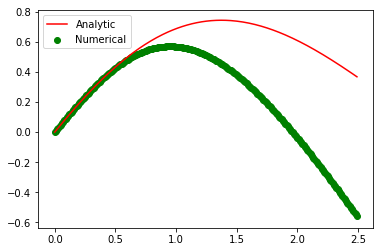

In [35]:
Xe2plot = np.arange(0,2.5, 0.01)
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0], 1, 1))
Ye2 = np.array([example2_trial_solution.predict(Xe2plot[i]) for i in range(Xe2plot.shape[0])]).reshape((Xe2plot.shape[0],))
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0],))
Ye22 = np.array([np.exp(-0.2*Xe2plot[i]) * np.sin(Xe2plot[i]) for i in range(Xe2plot.shape[0])])
plt.scatter(Xe2plot, Ye2, c='g', label='Numerical')
plt.plot(Xe2plot, Ye22, c='r', label='Analytic')
plt.legend()
plt.show()